TO DO

***Verify processes will only occur during specified times with specified labor
    -Breaks

***Fix National Carrier Processes
    -Labor split and breaks for pallets
    -Labor split and breaks for fluid

Determine the process tracking mechanism for a wholistic process

***Ensure appropriate completion times documented for all processes/partitions/carriers etc.

Determine if there is value in adding downtime for handoffs.
    -Specifically how to change between batch handoff process and dedicated handoff process.
    -Generally how should I consider handoffs and their impact in overall labor hour times

Consider building pallets or carts in a different way

***Evaluate the variance of processes based on historic rates and known numbers of team members





***Need to build and train the model which will predict the number of packages per truck and the time of arrival for the trucks

***Need to investigate if the distribution of packages follows any sort of trend, specifically partition 1, 2, 3, each of the national carriers
    -Would it be accurate to assume a random distribution of the packages based on a random splitting of the packages?






System process flow would occur as follows:
    1. Prediction model takes input of yesterday's or 2 day's prior volume, CART prediction, etc and generates a total expected volume
    2. The prediction model then predicts when the trucks will arrive based on their routebooks and historic arrivals
    3. Packages will be assigned a partition, or a national carrier based on the historical overall distribution of package compostion
    4. Packages will be assigned to trucks/pallets randomly or based on historical trends as far as truck fill rates.
    5. CSV file will be generated and fed to the simulation model (interim solution, full solution will just feed the df into the simulation)
    6. Simulation is run X times (say 1000) and the completion probability/carryover probability is calculated.
    7. Average of all the completion times is calculated and used to generate a progress tracker for each of the shifts 



# Define Classes, Libraries, and Global Variables that will be used across all simulations

In [1]:

from datetime import datetime, timedelta
import math
import numpy as np
import sim_generator as sg
import matplotlib.pyplot as plt
import pandas as pd
import simpy

class G:
    # Constants (adjust as needed)
    Process_Variance = 0.1
    UNLOADING_RATE = 60/15  # minutes per pallet
    UNLOADING_VARIANCE = Process_Variance  # 10% variance
    INDUCT_STAGE_RATE = 60/22  # minutes per pallet
    INDUCT_STAGE_VARIANCE = Process_Variance  # 10% variance
    INDUCTION_RATE = 60/800  # minutes per package
    INDUCTION_VARIANCE = Process_Variance  # 10% variance
    SPLITTER_RATE = 1/60  # minutes per package
    SPLITTER_VARIANCE = Process_Variance  # 10% variance
    TLMD_BUFFER_SORT_RATE = 60/148  # minutes per package
    TLMD_BUFFER_SORT_VARIANCE = Process_Variance  # 10% variance
    TLMD_PARTITION_STAGE_RATE = 1  # minutes per pallet
    TLMD_PARTITION_STAGE_VARIANCE = Process_Variance  # 10% variance
    TLMD_INDUCT_STAGE_RATE = 60/15  # minutes per pallet
    TLMD_INDUCT_STAGE_VARIANCE = Process_Variance  # 10% variance
    TLMD_INDUCTION_RATE = 60/300  # minutes per package
    TLMD_INDUCTION_VARIANCE = Process_Variance  # 10% variance
    TLMD_FINAL_SORT_RATE = 60/84  # minutes per package
    TLMD_FINAL_SORT_VARIANCE = Process_Variance  # 10% variance
    TLMD_CART_STAGE_RATE = 60/84  # minutes per cart
    TLMD_CART_STAGE_VARIANCE = Process_Variance  # 10% variance
    TLMD_CART_HANDOFF_RATE = 60/22  # minutes per pallet
    TLMD_CART_HANDOFF_VARIANCE = Process_Variance  # 10% variance
    CART_STAGE_RATE = 2  # minutes per cart
    CART_STAGE_VARIANCE = Process_Variance  # 10% variance
    TLMD_CART_HANDOFF_RATE = 2  # minutes per cart
    TLMD_CART_HANDOFF_VARIANCE = Process_Variance  # 10% variance
    NATIONAL_CARRIER_SORT_RATE = 60/148  # minutes per package
    NATIONAL_CARRIER_SORT_VARIANCE = Process_Variance  # 10% variance
    NC_PALLET_STAGING_RATE = 60/120  # minutes per pallet
    NC_PALLET_STAGING_VARIANCE = Process_Variance  # 10% variance

    


    OUTBOUND_NC_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    PARTITION_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    TLMD_PARTITION_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    NC_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    TLMD_CART_MAX_PACKAGES = 20  # Max packages per cart
    TOTAL_PACKAGES = None  # Total packages to be processed
    TOTAL_PACKAGES_TLMD = None  # Total TLMD packages to be processed
    TOTAL_PACKAGES_NC = None  # Total National Carrier packages to be processed
    TLMD_INDUCT_TIME = None
    TLMD_STAGED_PACKAGES = None
    TLMD_PARTITION_1_PACKAGES = None
    TLMD_PARTITION_2_PACKAGES = None
    TLMD_PARTITION_3_PACKAGES = None
    TOTAL_PALLETS_TLMD = None
    TLMD_PARTITION_1_SORT_TIME = None
    TLMD_PARTITION_2_SORT_TIME = None 
    TLMD_PARTITION_3_SORT_TIME = None
    TLMD_SORTED_PACKAGES = None
    TLMD_PARTITION_1_CART_STAGE_TIME = None
    TLMD_PARTITION_2_CART_STAGE_TIME = None 
    TLMD_PARTITION_3_CART_STAGE_TIME = None
    TLMD_OUTBOUND_PACKAGES = None
    I=1
    J=1
    K=1
    PASSED_OVER_PALLETS_1 = None
    PASSED_OVER_PALLETS_2 = None
    PASSED_OVER_PALLETS_3 = None

    TOTAL_PACKAGES_UPSN = None
    TOTAL_PACKAGES_USPS = None
    TOTAL_PACKAGES_FDEG = None
    TOTAL_PACKAGES_FDE = None
    UPSN_PALLETS = None
    USPS_PALLETS = None
    FDEG_PALLETS = None
    FDE_PALLETS = None
    UPSN_SORT_TIME = None
    USPS_SORT_TIME = None
    FDEG_SORT_TIME = None
    FDE_SORT_TIME = None

    TOTAL_CARTS_TLMD = None

    PARTITION_1_RATIO = 0.50  # Ratio of packages to go to partition 1
    PARTITION_2_RATIO = 0.35  # Ratio of packages to go to partition 2
    PARTITION_3_RATIO = 0.15  # Ratio of packages to go to partition 3

    USPS_DEPARTURE_TIME = [780]  # minutes
    UPSN_DEPARTURE_TIME = [1440]  # minutes
    FDEG_DEPARTURE_TIME = [180, 390]  # minutes
    FDE_DEPARTURE_TIME = [330]  # minutes

class Package:
    def __init__(self, tracking_number, pallet_id, scac):
        self.tracking_number = tracking_number
        self.pallet_id = pallet_id
        self.scac = scac
        self.current_queue = None

class Pallet:
    def __init__(self, env, pallet_id, packages, pkg_received_utc_ts):
        self.env = env
        self.pkg_received_utc_ts = pkg_received_utc_ts
        self.pallet_id = pallet_id
        self.packages = [Package(pkg[0], pallet_id, pkg[1]) for pkg in packages]
        self.current_queue = None
        self.remaining_packages = len(packages)  # Track remaining packages

class TLMD_Pallet:
    def __init__(self, env, pallet_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.pallet_id = pallet_id
        self.packages = packages
        self.current_packages = len(packages)  # Track remaining packages

    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f'Package {package.tracking_number} added to pallet {self.pallet_id} at {self.env.now}')
        print(f'Pallet currently contains {self.current_packages} packages')

class TLMD_Cart:
    def __init__(self, env, cart_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.cart_id = cart_id
        self.packages = packages
        self.current_packages = len(packages)  # Tracks packages
    
    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to cart {self.cart_id} at {self.env.now}")
        print(f'Cart currently contains {self.current_packages} packages')

class National_Carrier_Pallet:
    def __init__(self, env, pallet_id, packages, scac, built_time):
        self.env = env
        self.built_time = built_time
        self.pallet_id = pallet_id
        self.packages = packages
        self.scac = scac
        self.current_packages = len(packages)  # Track remaining packages

    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to pallet {self.pallet_id} at {self.env.now}")
        print(f'Pallet currently contains {self.current_packages} packages')


def make_resources_unavailable(env, sortation_center, start, end):
    yield env.timeout(start)
    print(f'Resources unavailable at {env.now}')
    sortation_center.resources_available = False
    yield env.timeout(end - start)
    print(f'Resources available at {env.now}')
    sortation_center.resources_available = True

def night_shift(env, sortation_center, start, end):
    #while True:
    yield env.timeout(start)
    print(f'Begin Night shift at {env.now}')
    sortation_center.night_shift = True
    yield env.timeout(end - start)
    sortation_center.night_shift = False
    print(f'Conclude Night shift at {env.now}')
    

def day_shift(env, sortation_center, start, end):
    #while True:
    yield env.timeout(start)
    print(f'Begin Day shift at {env.now}')
    sortation_center.day_shift = True
    yield env.timeout(end - start)
    sortation_center.day_shift = False
    print(f'Conclude Day shift at {env.now}')
    

def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['resource_utilization'])
    plt.title('util')
    plt.xlabel('Time')
    plt.ylabel('util')
    plt.legend()
    plt.show()

    for queue, lengths in metrics['queue_lengths'].items():
        plt.figure(figsize=(12, 8))
        plt.plot(lengths, label=queue)
        plt.title('Queue Length')
        plt.xlabel('Time')
        plt.ylabel('Queue Length')
        plt.legend()
        plt.show()

# 24 Hour Soration Center Process Classes

In [2]:
class Sortation_Center:
    def __init__(self, 
                env, 
                pallets_df, 
                night_tm_pit_unload, 
                night_tm_pit_induct, 
                night_tm_nonpit_split, 
                night_tm_nonpit_NC, 
                night_tm_nonpit_buffer,
                night_tm_TLMD_induct,
                night_tm_TLMD_picker,
                night_tm_TLMD_sort,
                night_tm_TLMD_stage,

                day_tm_pit_unload,
                day_tm_pit_induct,
                day_tm_nonpit_split,
                day_tm_nonpit_NC,
                day_tm_nonpit_buffer,
                day_tm_TLMD_induct,
                day_tm_TLMD_picker,
                day_tm_TLMD_sort,
                day_tm_TLMD_stage,
                ):
        
        self.env = env
        self.pallets_df = pallets_df
        self.night_tm_pit_unload = simpy.Resource(env, capacity=night_tm_pit_unload)
        self.night_tm_pit_induct = simpy.PriorityResource(env, capacity=night_tm_pit_induct)
        self.night_tm_nonpit_split = simpy.Resource(env, capacity=night_tm_nonpit_split)
        self.night_tm_nonpit_NC = simpy.PriorityResource(env, capacity=night_tm_nonpit_NC)
        self.night_tm_nonpit_buffer = simpy.PriorityResource(env, capacity=night_tm_nonpit_buffer)
        self.night_tm_TLMD_induct = simpy.PriorityResource(env, capacity=night_tm_TLMD_induct)
        self.night_tm_TLMD_picker = simpy.Resource(env, capacity=night_tm_TLMD_picker)
        self.night_tm_TLMD_sort = simpy.Resource(env, capacity=night_tm_TLMD_sort)
        self.night_tm_TLMD_stage = simpy.Resource(env, capacity=night_tm_TLMD_stage)

        self.day_tm_pit_unload = simpy.Resource(env, capacity=day_tm_pit_unload)
        self.day_tm_pit_induct = simpy.PriorityResource(env, capacity=day_tm_pit_induct)
        self.day_tm_nonpit_split = simpy.Resource(env, capacity=day_tm_nonpit_split)
        self.day_tm_nonpit_NC = simpy.PriorityResource(env, capacity=day_tm_nonpit_NC)
        self.day_tm_nonpit_buffer = simpy.PriorityResource(env, capacity=day_tm_nonpit_buffer)
        self.day_tm_TLMD_induct = simpy.PriorityResource(env, capacity=day_tm_TLMD_induct)
        self.day_tm_TLMD_picker = simpy.Resource(env, capacity=day_tm_TLMD_picker)
        self.day_tm_TLMD_sort = simpy.Resource(env, capacity=day_tm_TLMD_sort)
        self.day_tm_TLMD_stage = simpy.Resource(env, capacity=day_tm_TLMD_stage)


        #Used for consideration of breaks
        self.resources_available = True

        #flags used to control whether day shift resources or night shift resources are used.
        self.night_shift = False
        self.day_shift = False

        #flags to control the resources dedicated to processes
        self.inbound_flag = False
        self.TLMD_flag = False
        self.TLMD_sort = False
        self.TLMD_stage = False

        #flags for national carrier progress
        self.USPS_flag = False
        self.UPSN_flag = False
        self.FDEG_flag = False
        self.FDE_flag = False

        self.partition_1_flag = False
        self.partition_2_flag = False
        self.partition_3_flag = False

        self.queues = {
            'queue_inbound_truck': simpy.Store(self.env),
            'queue_inbound_staging': simpy.Store(self.env, capacity=200),
            'queue_induct_staging_pallets': simpy.Store(self.env),
            'queue_induct_staging_packages': simpy.Store(self.env),
            'queue_splitter': simpy.Store(self.env, capacity=1),
            'queue_tlmd_buffer_sort': simpy.Store(self.env, capacity=100000),
            'queue_national_carrier_sort': simpy.Store(self.env, capacity=100000),
            'queue_tlmd_pallet': simpy.Store(self.env, capacity=100000),
            'queue_tlmd_staged_pallet': simpy.Store(self.env, capacity=100000),  
            "queue_FDEG_pallet": simpy.Store(self.env),
            "queue_FDE_pallet": simpy.Store(self.env),
            "queue_USPS_pallet": simpy.Store(self.env),
            "queue_UPSN_pallet": simpy.Store(self.env), 
            'queue_FDEG_staged_pallet': simpy.Store(self.env),
            'queue_FDE_staged_pallet': simpy.Store(self.env),
            'queue_USPS_staged_pallet': simpy.Store(self.env),
            'queue_UPSN_staged_pallet': simpy.Store(self.env),
            'queue_FDEG_outbound_packages': simpy.Store(self.env),
            'queue_FDE_outbound_packages': simpy.Store(self.env),
            'queue_USPS_outbound_packages': simpy.Store(self.env),
            'queue_UPSN_outbound_packages': simpy.Store(self.env),
            'queue_tlmd_pallet_packages': simpy.Store(env),
            'queue_tlmd_1_staged_pallet': simpy.Store(env),
            'queue_tlmd_2_staged_pallet': simpy.Store(env),
            'queue_tlmd_3_staged_pallet': simpy.Store(env),
            'queue_tlmd_induct_staging_pallets' : simpy.Store(env, capacity=6),
            'queue_tlmd_induct_staging_packages' : simpy.Store(env),
            'queue_tlmd_splitter' : simpy.Store(env),
            'queue_tlmd_final_sort' : simpy.Store(env),
            'queue_tlmd_cart' : simpy.Store(env),  
            'queue_tlmd_1_cart' : simpy.Store(env),
            'queue_tlmd_2_cart' : simpy.Store(env),
            'queue_tlmd_3_cart' : simpy.Store(env),  
            'queue_tlmd_cart_1_staging' : simpy.Store(env),
            'queue_tlmd_cart_2_staging' : simpy.Store(env),
            'queue_tlmd_cart_3_staging' : simpy.Store(env),
            'queue_tlmd_cart_handoff' : simpy.Store(env),
        }

        self.metrics = {
            'processing_times': [],
            'queue_lengths': {key: [] for key in self.queues.keys()},
            'resource_utilization': [],
        }

        self.all_packages_staged_time = None

    def track_metrics(self):
        while True:
            for key, queue in self.queues.items():
                self.metrics['queue_lengths'][key].append(len(queue.items))
            self.metrics['resource_utilization'].append(len(self.night_tm_pit_unload.queue))
            yield self.env.timeout(1)

    def schedule_arrivals(self):
        for i, row in self.pallets_df.iterrows():
            pallet = Pallet(
                self.env,
                row['Pallet'],
                row['packages'],
                row['earliest_arrival']
            )
            self.env.process(self.truck_arrival(pallet))

    def truck_arrival(self, pallet):
        yield self.env.timeout(pallet.pkg_received_utc_ts) 
        pallet.current_queue = 'queue_inbound_truck'
        print(f'Pallet {pallet.pallet_id} arrived at {self.env.now}')
        yield self.queues['queue_inbound_truck'].put(pallet)
        self.env.process(self.unload_truck(pallet))

####################################
####inbound induct proces start#####
####################################

    def unload_truck(self, pallet):
        while not self.resources_available:
            yield self.env.timeout(1)  

        if self.night_shift and self.resources_available:
            with self.night_tm_pit_unload.request() as req:
                yield req
                yield self.queues['queue_inbound_truck'].get()
                yield self.env.timeout(G.UNLOADING_RATE)  # Unloading time
                pallet.current_queue = 'queue_inbound_staging'
                print(f'Pallet {pallet.pallet_id} unloaded at {self.env.now}')
                yield self.queues['queue_inbound_staging'].put(pallet)
                self.env.process(self.move_to_induct_staging(pallet))

        elif self.day_shift and self.resources_available:
            with self.day_tm_pit_unload.request() as req:
                yield req
                yield self.queues['queue_inbound_truck'].get()
                yield self.env.timeout(G.UNLOADING_RATE)  # Unloading time
                pallet.current_queue = 'queue_inbound_staging'
                print(f'Pallet {pallet.pallet_id} unloaded at {self.env.now}')
                yield self.queues['queue_inbound_staging'].put(pallet)
                self.env.process(self.move_to_induct_staging(pallet))

    def move_to_induct_staging(self, pallet):
        while not self.resources_available:
            yield self.env.timeout(1) 

        if self.night_shift and self.resources_available:
            with self.night_tm_pit_induct.request(priority=1) as req: 
                yield req
                yield self.queues['queue_inbound_staging'].get()
                yield self.env.timeout(G.INDUCT_STAGE_RATE)  # Unloading time
                pallet.current_queue = 'queue_induct_staging_pallets'
                yield self.queues['queue_induct_staging_pallets'].put(pallet)
                print(f'Pallet {pallet.pallet_id} staged for induction at {self.env.now}')
                for package in pallet.packages:
                    package.current_queue = 'queue_induct_staging_packages'
                    yield self.queues['queue_induct_staging_packages'].put(package)
                    self.env.process(self.induct_package(package, pallet))

        elif self.day_shift and self.resources_available:
            with self.day_tm_pit_induct.request(priority=1) as req:  # Lower priority
                yield req
                yield self.queues['queue_inbound_staging'].get()
                yield self.env.timeout(G.INDUCT_STAGE_RATE)  # Unloading time
                pallet.current_queue = 'queue_induct_staging_pallets'
                yield self.queues['queue_induct_staging_pallets'].put(pallet)
                print(f'Pallet {pallet.pallet_id} staged for induction at {self.env.now}')
                for package in pallet.packages:
                    package.current_queue = 'queue_induct_staging_packages'
                    yield self.queues['queue_induct_staging_packages'].put(package)
                    self.env.process(self.induct_package(package, pallet))

    def induct_package(self, package, pallet):
        while not self.resources_available:
            yield self.env.timeout(1)  

        if self.night_shift and self.resources_available:
            with self.night_tm_pit_induct.request(priority=0) as req:  
                yield req
                yield self.queues['queue_induct_staging_packages'].get()
                yield self.env.timeout(G.INDUCTION_RATE)
                package.current_queue = 'queue_splitter'
                print(f'Package {package.tracking_number}, {package.scac} inducted at {self.env.now}')
                yield self.queues['queue_splitter'].put(package)
                pallet.remaining_packages -= 1  # Decrement the counter
                if pallet.remaining_packages == 0:
                    # Remove the pallet from queue_induct_staging_pallets
                    self.remove_pallet_from_queue(pallet)
                self.env.process(self.split_package(package))
        
        elif self.day_shift and self.resources_available:
            with self.day_tm_pit_induct.request(priority=0) as req:
                yield req
                yield self.queues['queue_induct_staging_packages'].get()
                yield self.env.timeout(G.INDUCTION_RATE)
                package.current_queue = 'queue_splitter'
                print(f'Package {package.tracking_number}, {package.scac} inducted at {self.env.now}')
                yield self.queues['queue_splitter'].put(package)
                pallet.remaining_packages -= 1  
                if pallet.remaining_packages == 0:
                    # Remove the pallet from queue_induct_staging_pallets
                    self.remove_pallet_from_queue(pallet)
                self.env.process(self.split_package(package))
        
    def remove_pallet_from_queue(self, pallet):
        # Manually search for and remove the pallet from the queue
        for i, p in enumerate(self.queues['queue_induct_staging_pallets'].items):
            if p.pallet_id == pallet.pallet_id:
                del self.queues['queue_induct_staging_pallets'].items[i]
                print(f'Pallet {pallet.pallet_id} removed from queue_induct_staging_pallets at {self.env.now}')
                break

    def split_package(self, package):
        while not self.resources_available:
            yield self.env.timeout(1) 

        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_split.request() as req:
                yield req
                yield self.queues['queue_splitter'].get()
                if package.scac in ['UPSN', 'USPS', 'FDEG', 'FDE']:
                    package.current_queue = 'queue_national_carrier_sort'
                    print(f'Package {package.tracking_number} split to National Sort at {self.env.now}')
                    yield self.queues['queue_national_carrier_sort'].put(package)
                    self.env.process(self.national_carrier_sort(package))
                else:
                    package.current_queue = 'queue_tlmd_buffer_sort'
                    print(f'Package {package.tracking_number} split to TLMD Buffer at {self.env.now}')
                    yield self.queues['queue_tlmd_buffer_sort'].put(package)
                    self.env.process(self.tlmd_buffer_sort(package))

        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_split.request() as req:
                yield req
                yield self.queues['queue_splitter'].get()
                if package.scac in ['UPSN', 'USPS', 'FDEG', 'FDE']:
                    package.current_queue = 'queue_national_carrier_sort'
                    print(f'Package {package.tracking_number} split to National Sort at {self.env.now}')
                    yield self.queues['queue_national_carrier_sort'].put(package)
                    self.env.process(self.national_carrier_sort(package))
                else:
                    package.current_queue = 'queue_tlmd_buffer_sort'
                    print(f'Package {package.tracking_number} split to TLMD Buffer at {self.env.now}')
                    yield self.queues['queue_tlmd_buffer_sort'].put(package)
                    self.env.process(self.tlmd_buffer_sort(package))

    def national_carrier_sort(self, package):
        while not self.resources_available:
            yield self.env.timeout(1) 

        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_national_carrier_sort"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_SORT_RATE)
                if package.scac in ['UPSN']:
                    if not self.Fluid_status:
                        yield self.queues["queue_UPSN_pallet"].put(package)
                        self.env.process(self.check_all_UPSN_sorted())
                    else:
                        yield self.queues["queue_UPSN_fluid"].put(package)
                        self.env.process(self.national_carrier_fluid_split_UPSN(package))
                elif package.scac in ['USPS']:
                    if not self.Fluid_status:
                        yield self.queues["queue_USPS_pallet"].put(package)
                        self.env.process(self.check_all_USPS_sorted())
                    else:
                        yield self.queues["queue_USPS_fluid"].put(package)
                        self.env.process(self.national_carrier_fluid_split_USPS(package))
                elif package.scac in ['FDEG']:
                    if not self.Fluid_status:
                        yield self.queues["queue_FDEG_pallet"].put(package)
                        self.env.process(self.check_all_FDEG_sorted())
                    else:
                        yield self.queues["queue_FDEG_fluid"].put(package)
                        self.env.process(self.national_carrier_fluid_split_FDEG(package))
                elif package.scac in ['FDE']:
                    if not self.Fluid_status:
                        yield self.queues["queue_FDE_pallet"].put(package)
                        self.env.process(self.check_all_FDE_sorted())
                    else:
                        yield self.queues["queue_FDE_fluid"].put(package)
                        self.env.process(self.national_carrier_fluid_split_FDE(package))

    
        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_national_carrier_sort"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_SORT_RATE)
                if package.scac in ['UPSN']:
                    if not self.Fluid_status:
                        yield self.queues["queue_UPSN_pallet"].put(package)
                        self.env.process(self.check_all_UPSN_sorted())
                    else:
                        yield self.queues["queue_UPSN_fluid"].put(package)
                        self.env.process(self.national_carrier_fluid_split_UPSN(package))
                elif package.scac in ['USPS']:
                    if not self.Fluid_status:
                        yield self.queues["queue_USPS_pallet"].put(package)
                        self.env.process(self.check_all_USPS_sorted())
                    else:
                        yield self.queues["queue_USPS_fluid"].put(package)
                        self.env.process(self.national_carrier_fluid_split_USPS(package))
                elif package.scac in ['FDEG']:
                    if not self.Fluid_status:
                        yield self.queues["queue_FDEG_pallet"].put(package)
                        self.env.process(self.check_all_FDEG_sorted())
                    else:
                        yield self.queues["queue_FDEG_fluid"].put(package)
                        self.env.process(self.national_carrier_fluid_split_FDEG(package))
                elif package.scac in ['FDE']:
                    if not self.Fluid_status:
                        yield self.queues["queue_FDE_pallet"].put(package)
                        self.env.process(self.check_all_FDE_sorted())
                    else:
                        yield self.queues["queue_FDE_fluid"].put(package)
                        self.env.process(self.national_carrier_fluid_split_FDE(package))

    def check_all_UPSN_sorted(self):
        if len(self.queues['queue_UPSN_pallet'].items) == G.TOTAL_PACKAGES_UPSN:
            print(f'All UPSN packages sorted at {self.env.now}')
            G.UPSN_SORT_TIME = self.env.now 
            self.env.process(self.NC_UPSN_pallet_build())
        else:
            yield self.env.timeout(1)
            self.env.process(self.check_all_UPSN_sorted())

    def check_all_USPS_sorted(self):
        if len(self.queues['queue_USPS_pallet'].items) == G.TOTAL_PACKAGES_USPS:
            print(f'All USPS packages sorted at {self.env.now}')
            G.USPS_SORT_TIME = self.env.now
            self.env.process(self.NC_USPS_pallet_build())
        else:
            yield self.env.timeout(1)
            self.env.process(self.check_all_USPS_sorted())

    def check_all_FDEG_sorted(self):
        if  len(self.queues['queue_FDEG_pallet'].items) == G.TOTAL_PACKAGES_FDEG:
            print(f'All FDEG packages sorted at {self.env.now}')
            G.FDEG_SORT_TIME = self.env.now
            self.env.process(self.NC_FDEG_pallet_build())
        else:
            yield self.env.timeout(1)
            self.env.process(self.check_all_FDEG_sorted())

    def check_all_FDE_sorted(self):
        if  len(self.queues['queue_FDE_pallet'].items) == G.TOTAL_PACKAGES_FDE:
            print(f'All FDE packages sorted at {self.env.now}')
            G.FDE_SORT_TIME = self.env.now
            self.env.process(self.NC_FDE_pallet_build())
        else:
            yield self.env.timeout(1)
            self.env.process(self.check_all_FDE_sorted())           

    def NC_UPSN_pallet_build(self):
        UPSN_pallets = math.ceil(G.TOTAL_PACKAGES_UPSN / G.NC_PALLET_MAX_PACKAGES)
        print(f'UPSN: {UPSN_pallets} pallets')
        G.UPSN_PALLETS = UPSN_pallets

        def create_NC_pallets(NC_packages, NC_pallets, queue_name, staged_queue_name, scac):
            while not self.resources_available:
                yield self.env.timeout(1)  # Check every 1 time unit

            if self.night_shift and self.resources_available:
                with self.night_tm_nonpit_NC.request(priority=0) as req:
                    yield req
                    remaining_packages = NC_packages
                    for pallet_num in range(NC_pallets):
                        pallet_packages = []
                        packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)
                        for _ in range(packages_for_this_pallet):
                            pkg = yield self.queues[queue_name].get()
                            pallet_packages.append(pkg)
                            yield self.env.timeout(0)
                        pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                        G.K += 1
                        print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                        yield self.queues[staged_queue_name].put(pallet)
                        yield self.env.timeout(G.NC_PALLET_STAGING_RATE)
                        remaining_packages -= packages_for_this_pallet

            elif self.day_shift and self.resources_available:
                with self.day_tm_nonpit_NC.request(priority=0) as req:
                    yield req
                    remaining_packages = NC_packages
                    for pallet_num in range(NC_pallets):
                        pallet_packages = []
                        packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)
                        for _ in range(packages_for_this_pallet):
                            pkg = yield self.queues[queue_name].get()
                            pallet_packages.append(pkg)
                            yield self.env.timeout(0)
                        pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                        G.K += 1
                        print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                        yield self.queues[staged_queue_name].put(pallet)
                        yield self.env.timeout(G.NC_PALLET_STAGING_RATE)
                        remaining_packages -= packages_for_this_pallet

        yield self.env.process(create_NC_pallets(G.TOTAL_PACKAGES_UPSN, UPSN_pallets, 'queue_UPSN_pallet', 'queue_UPSN_staged_pallet','UPSN'))

    def NC_USPS_pallet_build(self):
        USPS_pallets = math.ceil(G.TOTAL_PACKAGES_USPS / G.NC_PALLET_MAX_PACKAGES)
        print(f'USPS: {USPS_pallets} pallets')
        G.USPS_PALLETS = USPS_pallets

        def create_NC_pallets(NC_packages, NC_pallets, queue_name, staged_queue_name, scac):
            while not self.resources_available:
                yield self.env.timeout(1)  # Check every 1 time unit

            if self.night_shift and self.resources_available:
                with self.night_tm_nonpit_NC.request(priority=0) as req:
                    yield req
                    remaining_packages = NC_packages
                    for pallet_num in range(NC_pallets):
                        pallet_packages = []
                        packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)
                        for _ in range(packages_for_this_pallet):
                            pkg = yield self.queues[queue_name].get()
                            pallet_packages.append(pkg)
                            yield self.env.timeout(0)
                        pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                        G.K += 1
                        print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                        yield self.queues[staged_queue_name].put(pallet)
                        yield self.env.timeout(G.NC_PALLET_STAGING_RATE)
                        remaining_packages -= packages_for_this_pallet

            elif self.day_shift and self.resources_available:
                with self.day_tm_nonpit_NC.request(priority=0) as req:
                    yield req
                    remaining_packages = NC_packages
                    for pallet_num in range(NC_pallets):
                        pallet_packages = []
                        packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)
                        for _ in range(packages_for_this_pallet):
                            pkg = yield self.queues[queue_name].get()
                            pallet_packages.append(pkg)
                            yield self.env.timeout(0)
                        pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                        G.K += 1
                        print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                        yield self.queues[staged_queue_name].put(pallet)
                        yield self.env.timeout(G.NC_PALLET_STAGING_RATE)
                        remaining_packages -= packages_for_this_pallet

        yield self.env.process(create_NC_pallets(G.TOTAL_PACKAGES_USPS, USPS_pallets, 'queue_USPS_pallet', 'queue_USPS_staged_pallet','USPS'))


    def NC_FDEG_pallet_build(self):
        FDEG_pallets = math.ceil(G.TOTAL_PACKAGES_FDEG / G.NC_PALLET_MAX_PACKAGES)
        print(f'FDEG: {FDEG_pallets} pallets')
        G.FDEG_PALLETS = FDEG_pallets

        def create_NC_pallets(NC_packages, NC_pallets, queue_name, staged_queue_name, scac):
            while not self.resources_available:
                yield self.env.timeout(1)  # Check every 1 time unit

            if self.night_shift and self.resources_available:
                with self.night_tm_nonpit_NC.request(priority=0) as req:
                    yield req
                    remaining_packages = NC_packages
                    for pallet_num in range(NC_pallets):
                        pallet_packages = []
                        packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)
                        for _ in range(packages_for_this_pallet):
                            pkg = yield self.queues[queue_name].get()
                            pallet_packages.append(pkg)
                            yield self.env.timeout(0)
                        pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                        G.K += 1
                        print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                        yield self.queues[staged_queue_name].put(pallet)
                        yield self.env.timeout(G.NC_PALLET_STAGING_RATE)
                        remaining_packages -= packages_for_this_pallet

            elif self.day_shift and self.resources_available:
                with self.day_tm_nonpit_NC.request(priority=0) as req:
                    yield req
                    remaining_packages = NC_packages
                    for pallet_num in range(NC_pallets):
                        pallet_packages = []
                        packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)
                        for _ in range(packages_for_this_pallet):
                            pkg = yield self.queues[queue_name].get()
                            pallet_packages.append(pkg)
                            yield self.env.timeout(0)
                        pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                        G.K += 1
                        print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                        yield self.queues[staged_queue_name].put(pallet)
                        yield self.env.timeout(G.NC_PALLET_STAGING_RATE)
                        remaining_packages -= packages_for_this_pallet

        yield self.env.process(create_NC_pallets(G.TOTAL_PACKAGES_FDEG, FDEG_pallets, 'queue_FDEG_pallet', 'queue_FDEG_staged_pallet','FDEG'))


    def NC_FDE_pallet_build(self):
        FDE_pallets = math.ceil(G.TOTAL_PACKAGES_FDE / G.NC_PALLET_MAX_PACKAGES)
        print(f'FDE: {FDE_pallets} pallets')
        G.FDE_PALLETS = FDE_pallets

        def create_NC_pallets(NC_packages, NC_pallets, queue_name, staged_queue_name, scac):
            while not self.resources_available:
                yield self.env.timeout(1)  # Check every 1 time unit

            if self.night_shift and self.resources_available:
                with self.night_tm_nonpit_NC.request(priority=0) as req:
                    yield req
                    remaining_packages = NC_packages               
                    for pallet_num in range(NC_pallets):
                        pallet_packages = []
                        packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)                       
                        for _ in range(packages_for_this_pallet):
                            pkg = yield self.queues[queue_name].get()
                            pallet_packages.append(pkg)
                            yield self.env.timeout(0)                        
                        pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                        G.K += 1
                        print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')                        
                        yield self.queues[staged_queue_name].put(pallet)
                        yield self.env.timeout(G.NC_PALLET_STAGING_RATE)                      
                        remaining_packages -= packages_for_this_pallet
    
            elif self.day_shift and self.resources_available:
                with self.day_tm_nonpit_NC.request(priority=0) as req:
                    yield req
                    remaining_packages = NC_packages               
                    for pallet_num in range(NC_pallets):
                        pallet_packages = []
                        packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)                       
                        for _ in range(packages_for_this_pallet):
                            pkg = yield self.queues[queue_name].get()
                            pallet_packages.append(pkg)
                            yield self.env.timeout(0)                        
                        pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                        G.K += 1
                        print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')                        
                        yield self.queues[staged_queue_name].put(pallet)
                        yield self.env.timeout(G.NC_PALLET_STAGING_RATE)                      
                        remaining_packages -= packages_for_this_pallet

        yield self.env.process(create_NC_pallets(G.TOTAL_PACKAGES_FDE, FDE_pallets, 'queue_FDE_pallet', 'queue_FDE_staged_pallet','FDE'))

########################################################
##### Begin National Carrier Fluid Load Process#########
########################################################

    def national_carrier_fluid_split_UPSN(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)
            
        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_UPSN_fluid"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
                print(f"Package {package.tracking_number} sorted to UPSN fluid at {self.env.now}")
                yield self.queues["queue_UPSN_truck"].put(package)
                self.env.process(self.national_carrier_fluid_load_UPSN(package))

        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_UPSN_fluid"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
                print(f"Package {package.tracking_number} sorted to UPSN fluid at {self.env.now}")
                yield self.queues["queue_UPSN_truck"].put(package)
                self.env.process(self.national_carrier_fluid_load_UPSN(package))

    def national_carrier_fluid_load_UPSN(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)
            
        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_UPSN_truck"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
                print(f"Package {package.tracking_number} fulid loaded to UPSN at {self.env.now}")
                yield self.queues["queue_UPSN_Outbound"].put(package)

        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_UPSN_truck"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
                print(f"Package {package.tracking_number} fulid loaded to UPSN at {self.env.now}")
                yield self.queues["queue_UPSN_Outbound"].put(package)

    def national_carrier_fluid_split_USPS(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)

        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_USPS_fluid"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
                print(f"Package {package.tracking_number} sorted to USPS fluid at {self.env.now}")
                yield self.queues["queue_USPS_truck"].put(package)
                self.env.process(self.national_carrier_fluid_load_USPS(package))

        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_USPS_fluid"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
                print(f"Package {package.tracking_number} sorted to USPS fluid at {self.env.now}")
                yield self.queues["queue_USPS_truck"].put(package)
                self.env.process(self.national_carrier_fluid_load_USPS(package))

    def national_carrier_fluid_load_USPS(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)

        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_USPS_truck"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
                print(f"Package {package.tracking_number} fulid loaded to USPS at {self.env.now}")
                yield self.queues["queue_USPS_Outbound"].put(package)

        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_USPS_truck"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
                print(f"Package {package.tracking_number} fulid loaded to USPS at {self.env.now}")
                yield self.queues["queue_USPS_Outbound"].put(package)


    def national_carrier_fluid_split_FDEG(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)

        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_FDEG_fluid"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
                print(f"Package {package.tracking_number} sorted to FDEG fluid at {self.env.now}")
                yield self.queues["queue_FDEG_truck"].put(package)
                self.env.process(self.national_carrier_fluid_load_FDEG(package))

        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_FDEG_fluid"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
                print(f"Package {package.tracking_number} sorted to FDEG fluid at {self.env.now}")
                yield self.queues["queue_FDEG_truck"].put(package)
                self.env.process(self.national_carrier_fluid_load_FDEG(package))

    def national_carrier_fluid_load_FDEG(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)

        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_FDEG_truck"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
                print(f"Package {package.tracking_number} fulid loaded to FDEG at {self.env.now}")
                yield self.queues["queue_FDEG_Outbound"].put(package)

        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_FDEG_truck"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
                print(f"Package {package.tracking_number} fulid loaded to FDEG at {self.env.now}")
                yield self.queues["queue_FDEG_Outbound"].put(package)


    def national_carrier_fluid_split_FDE(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)  

        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_FDE_fluid"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
                print(f"Package {package.tracking_number} sorted to FDE fluid at {self.env.now}")
                yield self.queues["queue_FDE_truck"].put(package)
                self.env.process(self.national_carrier_fluid_load_FDE(package))

        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_FDE_fluid"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
                print(f"Package {package.tracking_number} sorted to FDE fluid at {self.env.now}")
                yield self.queues["queue_FDE_truck"].put(package)
                self.env.process(self.national_carrier_fluid_load_FDE(package))

    def national_carrier_fluid_load_FDE(self, package):
        while not self.resources_available:
            yield self.env.timeout(1) 

        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_FDE_truck"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
                print(f"Package {package.tracking_number} fulid loaded to FDE at {self.env.now}")
                yield self.queues["queue_FDE_Outbound"].put(package)

        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_NC.request(priority=1) as req:
                yield req
                yield self.queues["queue_FDE_truck"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
                print(f"Package {package.tracking_number} fulid loaded to FDE at {self.env.now}")
                yield self.queues["queue_FDE_Outbound"].put(package)

    ########################################################
    ############## Begin TLMD Sort Process #################
    ########################################################
    
    # this will need to be updated to include the logic associated with the different partitions
    def tlmd_buffer_sort(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)

        if self.night_shift and self.resources_available:
            with self.night_tm_nonpit_buffer.request(priority=1) as req:
                yield req
                yield self.queues['queue_tlmd_buffer_sort'].get()
                yield self.env.timeout(G.TLMD_BUFFER_SORT_RATE)
                print(f'Package {package.tracking_number} sorted to TLMD Buffer at {self.env.now}')
                yield self.queues['queue_tlmd_pallet'].put(package)
                self.env.process(self.check_all_packages_staged())

        elif self.day_shift and self.resources_available:
            with self.day_tm_nonpit_buffer.request(priority=1) as req:
                yield req
                yield self.queues['queue_tlmd_buffer_sort'].get()
                yield self.env.timeout(G.TLMD_BUFFER_SORT_RATE)
                print(f'Package {package.tracking_number} sorted to TLMD Buffer at {self.env.now}')
                yield self.queues['queue_tlmd_pallet'].put(package)
                self.env.process(self.check_all_packages_staged())

       
    #determine if queue_tlmd_staged_pallet holds the same number of packages as total_packages and if so, record the time
    def check_all_packages_staged(self):
        
        if len(self.queues['queue_tlmd_pallet'].items) == G.TOTAL_PACKAGES_TLMD:
            
            self.all_packages_staged_time = self.env.now
            G.TLMD_INDUCT_TIME = self.all_packages_staged_time
            print(f'All packages staged at {self.all_packages_staged_time}')
            G.TLMD_STAGED_PACKAGES = self.queues['queue_tlmd_pallet'].items
            self.env.process(self.TLMD_pallet_build())
        else:
            yield self.env.timeout(1)
            self.env.process(self.check_all_packages_staged())


    def TLMD_pallet_build(self):
    # Calculate the number of packages in each partition
        partition_1_packages = round(G.PARTITION_1_RATIO * G.TOTAL_PACKAGES_TLMD)
        partition_2_packages = round(G.PARTITION_2_RATIO * G.TOTAL_PACKAGES_TLMD)
        partition_3_packages = round(G.PARTITION_3_RATIO * G.TOTAL_PACKAGES_TLMD)

        G.TLMD_PARTITION_1_PACKAGES = partition_1_packages
        G.TLMD_PARTITION_2_PACKAGES = partition_2_packages
        G.TLMD_PARTITION_3_PACKAGES = partition_3_packages

        print(f'Partition 1: {partition_1_packages} packages')
        print(f'Partition 2: {partition_2_packages} packages')
        print(f'Partition 3: {partition_3_packages} packages')
        print(f'Total packages: {partition_1_packages + partition_2_packages + partition_3_packages}')

        # Handle any rounding discrepancies
        if partition_1_packages + partition_2_packages + partition_3_packages != G.TOTAL_PACKAGES_TLMD:
            partition_1_packages += G.TOTAL_PACKAGES_TLMD - (partition_1_packages + partition_2_packages + partition_3_packages)
            print(f'Adjusted Partition 1: {partition_1_packages} packages')

        # Calculate the number of pallets needed for each partition
        partition_1_pallets = math.ceil(partition_1_packages / G.TLMD_PARTITION_PALLET_MAX_PACKAGES)
        partition_2_pallets = math.ceil(partition_2_packages / G.TLMD_PARTITION_PALLET_MAX_PACKAGES)
        partition_3_pallets = math.ceil(partition_3_packages / G.TLMD_PARTITION_PALLET_MAX_PACKAGES)
        G.TOTAL_PALLETS_TLMD = partition_1_pallets + partition_2_pallets + partition_3_pallets
        print(f'total pallets: {G.TOTAL_PALLETS_TLMD}')
        print(f'Partition 1: {partition_1_pallets} pallets')
        print(f'Partition 2: {partition_2_pallets} pallets')
        print(f'Partition 3: {partition_3_pallets} pallets')

        # Function to create pallets for a given partition
        def create_pallets(partition_packages, partition_pallets, queue_name, staged_queue_name):
            while not self.resources_available:
                yield self.env.timeout(1)  # Check every 1 time unit

            remaining_packages = partition_packages
            for pallet_num in range(partition_pallets):
                pallet_packages = []
                packages_for_this_pallet = min(G.TLMD_PARTITION_PALLET_MAX_PACKAGES, remaining_packages)
                for _ in range(packages_for_this_pallet):
                    pkg = yield self.queues[queue_name].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(0)
                pallet = TLMD_Pallet(self.env, f'Pallet_{G.I}', pallet_packages, self.env.now)
                G.I += 1
                print(f'TLMD {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                yield self.queues[staged_queue_name].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.check_all_pallets_staged())
                remaining_packages -= packages_for_this_pallet

        # Create pallets for each partition
        yield self.env.process(create_pallets(partition_1_packages, partition_1_pallets, 'queue_tlmd_pallet', 'queue_tlmd_1_staged_pallet'))
        yield self.env.process(create_pallets(partition_2_packages, partition_2_pallets, 'queue_tlmd_pallet', 'queue_tlmd_2_staged_pallet'))
        yield self.env.process(create_pallets(partition_3_packages, partition_3_pallets, 'queue_tlmd_pallet', 'queue_tlmd_3_staged_pallet'))

    def check_all_pallets_staged(self):
        while len(self.queues['queue_tlmd_1_staged_pallet'].items) + len(self.queues['queue_tlmd_2_staged_pallet'].items) + len(self.queues['queue_tlmd_3_staged_pallet'].items) < G.TOTAL_PALLETS_TLMD:
            yield self.env.timeout(1)
        print(f'All pallets staged at {self.env.now}')
        self.env.process(self.feed_TLMD_induct_staging())

    def feed_TLMD_induct_staging(self):
        print(f'value of night shift {self.night_shift}')
        while (len(self.queues['queue_tlmd_1_staged_pallet'].items) > 0 or 
               len(self.queues['queue_tlmd_2_staged_pallet'].items) > 0 or 
               len(self.queues['queue_tlmd_3_staged_pallet'].items) > 0):
            if self.night_shift and self.resources_available:
                with self.night_tm_TLMD_induct.request(priority=1) as req:
                    yield req
                    if len(self.queues['queue_tlmd_1_staged_pallet'].items) > 0:
                        pallet = yield self.queues['queue_tlmd_1_staged_pallet'].get()
                    elif len(self.queues['queue_tlmd_2_staged_pallet'].items) > 0:
                        pallet = yield self.queues['queue_tlmd_2_staged_pallet'].get()
                    else:
                        pallet = yield self.queues['queue_tlmd_3_staged_pallet'].get()
                    yield self.env.timeout(G.TLMD_INDUCT_STAGE_RATE)  
                    pallet.current_queue = 'queue_tlmd_induct_staging_pallets'
                    yield self.queues['queue_tlmd_induct_staging_pallets'].put(pallet)
                    print(f'Pallet {pallet.pallet_id} staged for TLMD induction at {self.env.now}')
                    for package in pallet.packages:
                        package.current_queue = 'queue_tlmd_induct_staging_packages'
                        yield self.queues['queue_tlmd_induct_staging_packages'].put(package)
                        self.env.process(self.tlmd_induct_package(package, pallet))

            elif self.day_shift and self.resources_available:
                with self.day_tm_TLMD_induct.request(priority=1) as req:  
                    yield req
                    if len(self.queues['queue_tlmd_1_staged_pallet'].items) > 0:
                        pallet = yield self.queues['queue_tlmd_1_staged_pallet'].get()
                        print(f'grabbed pallet {pallet.pallet_id} from queue_tlmd_1_staged_pallet at {self.env.now}')
                    elif len(self.queues['queue_tlmd_2_staged_pallet'].items) > 0:
                        pallet = yield self.queues['queue_tlmd_2_staged_pallet'].get()
                        print(f'grabbed pallet {pallet.pallet_id} from queue_tlmd_2_staged_pallet at {self.env.now}')
                    else:
                        pallet = yield self.queues['queue_tlmd_3_staged_pallet'].get()
                        print(f'grabbed pallet {pallet.pallet_id} from queue_tlmd_3_staged_pallet at {self.env.now}')
                    yield self.env.timeout(G.TLMD_INDUCT_STAGE_RATE) 
                    pallet.current_queue = 'queue_tlmd_induct_staging_pallets'
                    yield self.queues['queue_tlmd_induct_staging_pallets'].put(pallet)
                    print(f'Pallet {pallet.pallet_id} staged for TLMD induction at {self.env.now}')
                    for package in pallet.packages:
                        package.current_queue = 'queue_tlmd_induct_staging_packages'
                        yield self.queues['queue_tlmd_induct_staging_packages'].put(package)
                        self.env.process(self.tlmd_induct_package(package, pallet))

    def tlmd_induct_package(self, package, pallet):
        while not self.resources_available:
            yield self.env.timeout(1)  

        if self.night_shift and self.resources_available:
            with self.night_tm_TLMD_induct.request(priority=0) as req:  
                yield req
                yield self.queues['queue_tlmd_induct_staging_packages'].get()
                yield self.env.timeout(G.INDUCTION_RATE)
                package.current_queue = 'queue_tlmd_splitter'
                print(f'Package {package.tracking_number}, {package.scac} inducted at TLMD at {self.env.now}')
                yield self.queues['queue_tlmd_splitter'].put(package)
                pallet.current_packages -= 1  
                if pallet.current_packages == 0:
                    # Remove the pallet from queue_induct_staging_pallets
                    self.tlmd_remove_pallet_from_queue(pallet)
                self.env.process(self.tlmd_lane_pickoff(package))

        elif self.day_shift and self.resources_available:
            with self.day_tm_TLMD_induct.request(priority=0) as req:  
                yield req
                yield self.queues['queue_tlmd_induct_staging_packages'].get()
                yield self.env.timeout(G.INDUCTION_RATE)
                package.current_queue = 'queue_tlmd_splitter'
                print(f'Package {package.tracking_number}, {package.scac} inducted at TLMD at {self.env.now}')
                yield self.queues['queue_tlmd_splitter'].put(package)
                pallet.current_packages -= 1  
                if pallet.current_packages == 0:
                    # Remove the pallet from queue_induct_staging_pallets
                    self.tlmd_remove_pallet_from_queue(pallet)
                self.env.process(self.tlmd_lane_pickoff(package))

    def tlmd_remove_pallet_from_queue(self, pallet):
        # Manually search for and remove the pallet from the queue
        for i, p in enumerate(self.queues['queue_tlmd_induct_staging_pallets'].items):
            if p.pallet_id == pallet.pallet_id:
                del self.queues['queue_tlmd_induct_staging_pallets'].items[i]
                print(f'Pallet {pallet.pallet_id} removed from queue_tlmd_induct_staging_pallets at {self.env.now}')
                break
    
    def tlmd_lane_pickoff(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)

        if self.night_shift and self.resources_available:
            with self.night_tm_TLMD_picker.request() as req:
                yield req
                yield self.queues['queue_tlmd_splitter'].get()
                yield self.env.timeout(G.SPLITTER_RATE)
                package.current_queue = 'queue_tlmd_final_sort'
                print(f'Package {package.tracking_number} split to TLMD Final Sort at {self.env.now}')
                yield self.queues['queue_tlmd_final_sort'].put(package)
                self.env.process(self.tlmd_final_sort(package))

        elif self.day_shift and self.resources_available:
            with self.day_tm_TLMD_picker.request() as req:
                yield req
                yield self.queues['queue_tlmd_splitter'].get()
                yield self.env.timeout(G.SPLITTER_RATE)
                package.current_queue = 'queue_tlmd_final_sort'
                print(f'Package {package.tracking_number} split to TLMD Final Sort at {self.env.now}')
                yield self.queues['queue_tlmd_final_sort'].put(package)
                self.env.process(self.tlmd_final_sort(package))

    
    def tlmd_final_sort(self, package):
        while not self.resources_available: 
            yield self.env.timeout(1) 

        if self.night_shift and self.resources_available:
            with self.night_tm_TLMD_sort.request() as req:
                yield req
                yield self.queues['queue_tlmd_final_sort'].get()
                yield self.env.timeout(G.TLMD_BUFFER_SORT_RATE)
                print(f'Package {package.tracking_number} sorted to TLMD Cart at {self.env.now}')
                yield self.queues['queue_tlmd_cart'].put(package)
                self.env.process(self.check_all_TLMD_sorted())

        elif self.day_shift and self.resources_available:
            with self.day_tm_TLMD_sort.request() as req:
                yield req
                yield self.queues['queue_tlmd_final_sort'].get()
                yield self.env.timeout(G.TLMD_BUFFER_SORT_RATE)
                print(f'Package {package.tracking_number} sorted to TLMD Cart at {self.env.now}')
                yield self.queues['queue_tlmd_cart'].put(package)
                self.env.process(self.check_all_TLMD_sorted())

    def check_all_TLMD_sorted(self):
        if (
            not self.partition_1_flag
            and len(self.queues['queue_tlmd_1_staged_pallet'].items) == 0
            and len(self.queues['queue_tlmd_cart'].items) >= G.TLMD_PARTITION_1_PACKAGES
        ):
                all_packages_staged_time_1 = self.env.now
                G.TLMD_PARTITION_1_SORT_TIME = all_packages_staged_time_1
                print(f'All partition 1 packages sorted at {all_packages_staged_time_1}')
                self.partition_1_flag = True  # Mark this partition as handled

        # Check for partition 2 only if partition 1 is done
        elif (
            not self.partition_2_flag
            and self.partition_1_flag  # Ensure partition 1 is done
            and len(self.queues['queue_tlmd_2_staged_pallet'].items) == 0
            and len(self.queues['queue_tlmd_cart'].items) >= G.TLMD_PARTITION_2_PACKAGES + G.TLMD_PARTITION_1_PACKAGES
        ):
            all_packages_staged_time_2 = self.env.now
            G.TLMD_PARTITION_2_SORT_TIME = all_packages_staged_time_2
            print(f'All partition 2 packages sorted at {all_packages_staged_time_2}')
            self.partition_2_flag = True  # Mark this partition as handled

        # Check for partition 3 only if partition 2 is done
        elif (
            not self.partition_3_flag
            and self.partition_2_flag  # Ensure partition 2 is done
            and len(self.queues['queue_tlmd_cart'].items) >= G.TLMD_PARTITION_3_PACKAGES + G.TLMD_PARTITION_2_PACKAGES + G.TLMD_PARTITION_1_PACKAGES
        ):
            all_packages_staged_time_3 = self.env.now
            G.TLMD_PARTITION_3_SORT_TIME = all_packages_staged_time_3
            print(f'All partition 3 packages sorted at {all_packages_staged_time_3}')
            self.partition_3_flag = True  # Mark this partition as handled

        # Check if all partitions are done
        if self.partition_1_flag and self.partition_2_flag and self.partition_3_flag:
            G.TLMD_SORTED_PACKAGES = self.queues['queue_tlmd_cart'].items
            print(f'All {len(G.TLMD_SORTED_PACKAGES)} TLMD packages sorted at {self.env.now}')
            #self.env.process(self.TLMD_cart_build())
        
        else:
            G.PASSED_OVER_PALLETS_1 = self.queues['queue_tlmd_1_staged_pallet'].items
            G.PASSED_OVER_PALLETS_2 = self.queues['queue_tlmd_2_staged_pallet'].items
            G.PASSED_OVER_PALLETS_3 = self.queues['queue_tlmd_3_staged_pallet'].items

        yield self.env.timeout(0)

    def TLMD_cart_build(self):
        partition_1_packages = G.TLMD_PARTITION_1_PACKAGES
        partition_2_packages = G.TLMD_PARTITION_2_PACKAGES
        partition_3_packages = G.TLMD_PARTITION_3_PACKAGES
    
        
        print(f'Partition 1: {partition_1_packages} packages')
        print(f'Partition 2: {partition_2_packages} packages')
        print(f'Partition 3: {partition_3_packages} packages')
        print(f'Total packages: {partition_1_packages + partition_2_packages + partition_3_packages}')
        
        # Calculate the number of pallets needed for each partition
        partition_1_carts = math.ceil(partition_1_packages / G.TLMD_CART_MAX_PACKAGES)
        partition_2_carts = math.ceil(partition_2_packages / G.TLMD_CART_MAX_PACKAGES)
        partition_3_carts = math.ceil(partition_3_packages / G.TLMD_CART_MAX_PACKAGES)

        print(f'Partition 1: {partition_1_carts} carts')
        print(f'Partition 2: {partition_2_carts} carts')
        print(f'Partition 3: {partition_3_carts} carts')
        print(F'total carts: {partition_1_carts + partition_2_carts + partition_3_carts}')

        G.TOTAL_CARTS_TLMD = partition_1_carts + partition_2_carts + partition_3_carts

    def run_simulation(self, until):
        return self.env.timeout(until)


In [3]:
def setup_simulation(day_pallets, 
                    night_tm_pit_unload, 
                    night_tm_pit_induct, 
                    night_tm_nonpit_split, 
                    night_tm_nonpit_NC, 
                    night_tm_nonpit_buffer,
                    night_tm_TLMD_induct,
                    night_tm_TLMD_picker,
                    night_tm_TLMD_sort,
                    night_tm_TLMD_stage,

                    day_tm_pit_unload,
                    day_tm_pit_induct,
                    day_tm_nonpit_split,
                    day_tm_nonpit_NC,
                    day_tm_nonpit_buffer,
                    day_tm_TLMD_induct,
                    day_tm_TLMD_picker,
                    day_tm_TLMD_sort,
                    day_tm_TLMD_stage,
                    unavailable_periods=None,
                    night_shift_period=None,
                    day_shift_period=None,
                    ):
        



    total_TMs_night = night_tm_pit_unload + night_tm_pit_induct + night_tm_nonpit_split + night_tm_nonpit_NC + night_tm_nonpit_buffer
    total_packages = sum([len(row['packages']) for i, row in day_pallets.iterrows()])
    all_packages = [pkg for sublist in pallet_info['packages'] for pkg in sublist]
    total_packages_NC = len([pkg for pkg in all_packages if pkg[1] in ['UPSN', 'USPS', 'FDEG', 'FDE']])
    total_packages_UPSN = len([pkg for pkg in all_packages if pkg[1] in ['UPSN']])
    total_packages_USPS = len([pkg for pkg in all_packages if pkg[1] in ['USPS']])
    total_packages_FDEG = len([pkg for pkg in all_packages if pkg[1] in ['FDEG']])
    total_packages_FDE = len([pkg for pkg in all_packages if pkg[1] in ['FDE']])

    total_packages_TLMD = total_packages - total_packages_NC

    print(f'Total Inbound Packages: {total_packages}')
    print(f'Total Inbound TLMD Packages: {total_packages_TLMD}')
    print(f'Total Inbound NC Packages: {total_packages_NC}')
    print(f'Total Inbound UPSN Packages: {total_packages_UPSN}')
    print(f'Total Inbound USPS Packages: {total_packages_USPS}')
    print(f'Total Inbound FDEG Packages: {total_packages_FDEG}')
    print(f'Total Inbound FDE Packages: {total_packages_FDE}')


    G.TOTAL_PACKAGES = total_packages
    G.TOTAL_PACKAGES_TLMD = total_packages_TLMD
    G.TOTAL_PACKAGES_NC = total_packages_NC 
    G.TOTAL_PACKAGES_UPSN = total_packages_UPSN
    G.TOTAL_PACKAGES_USPS = total_packages_USPS
    G.TOTAL_PACKAGES_FDEG = total_packages_FDEG
    G.TOTAL_PACKAGES_FDE = total_packages_FDE
    

    Fluid_status = total_TMs_night >= 20 and total_packages >= 15000

    env = simpy.Environment()

    sortation_center = Sortation_Center(
        env, 
        day_pallets, 
        night_tm_pit_unload, 
        night_tm_pit_induct, 
        night_tm_nonpit_split, 
        night_tm_nonpit_NC, 
        night_tm_nonpit_buffer,
        night_tm_TLMD_induct,
        night_tm_TLMD_picker,
        night_tm_TLMD_sort,
        night_tm_TLMD_stage,

        day_tm_pit_unload,
        day_tm_pit_induct,
        day_tm_nonpit_split,
        day_tm_nonpit_NC,
        day_tm_nonpit_buffer,
        day_tm_TLMD_induct,
        day_tm_TLMD_picker,
        day_tm_TLMD_sort,
        day_tm_TLMD_stage,
        Fluid_status
    )

    # Start tracking metrics and schedule arrivals
    env.process(sortation_center.track_metrics())
    sortation_center.schedule_arrivals()

    # Set up unavailable periods for resources
    if unavailable_periods:
        for start, end in unavailable_periods:
            env.process(make_resources_unavailable(env, sortation_center, start, end))

    if night_shift_period:
        for start, end in night_shift_period:
            env.process(night_shift(env, sortation_center, start, end))


    if day_shift_period:
        for start, end in day_shift_period:
            env.process(day_shift(env, sortation_center, start, end))

   

    night_shift(env, sortation_center, start, end)

    return env, sortation_center




Predicted Total Volume: 15706


c:\Users\fenst\Documents\Python\Practice\demand_generator.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['planned_arrival_datetime'] = pd.to_datetime(filtered_df['planned_arrival_datetime'])
c:\Users\fenst\Documents\Python\Practice\demand_generator.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['actual_arrival_datetime'] = pd.to_datetime(filtered_df['actual_arrival_datetime'])


Total Inbound Packages: 10613
Total Inbound TLMD Packages: 5425
Total Inbound NC Packages: 5188
Total Inbound UPSN Packages: 1389
Total Inbound USPS Packages: 2124
Total Inbound FDEG Packages: 1675
Total Inbound FDE Packages: 0
Begin Induct Process
Begin Night shift at 0
Pallet 1 arrived at 53.33212100556139
Pallet 2 arrived at 53.33212100556139
Pallet 3 arrived at 53.33212100556139
Pallet 4 arrived at 53.33212100556139
Pallet 5 arrived at 53.33212100556139
Pallet 6 arrived at 53.33212100556139
Pallet 7 arrived at 53.33212100556139
Pallet 8 arrived at 53.33212100556139
Pallet 9 arrived at 53.33212100556139
Pallet 10 arrived at 53.33212100556139
Pallet 11 arrived at 53.33212100556139
Pallet 12 arrived at 53.33212100556139
Pallet 13 arrived at 53.33212100556139
Pallet 14 arrived at 53.33212100556139
Pallet 15 arrived at 53.33212100556139
Pallet 16 arrived at 53.33212100556139
Pallet 17 arrived at 53.33212100556139
Pallet 18 arrived at 53.33212100556139
Pallet 19 arrived at 53.33212100556

C:\Users\fenst\AppData\Local\Temp\ipykernel_26724\1885799339.py:196: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


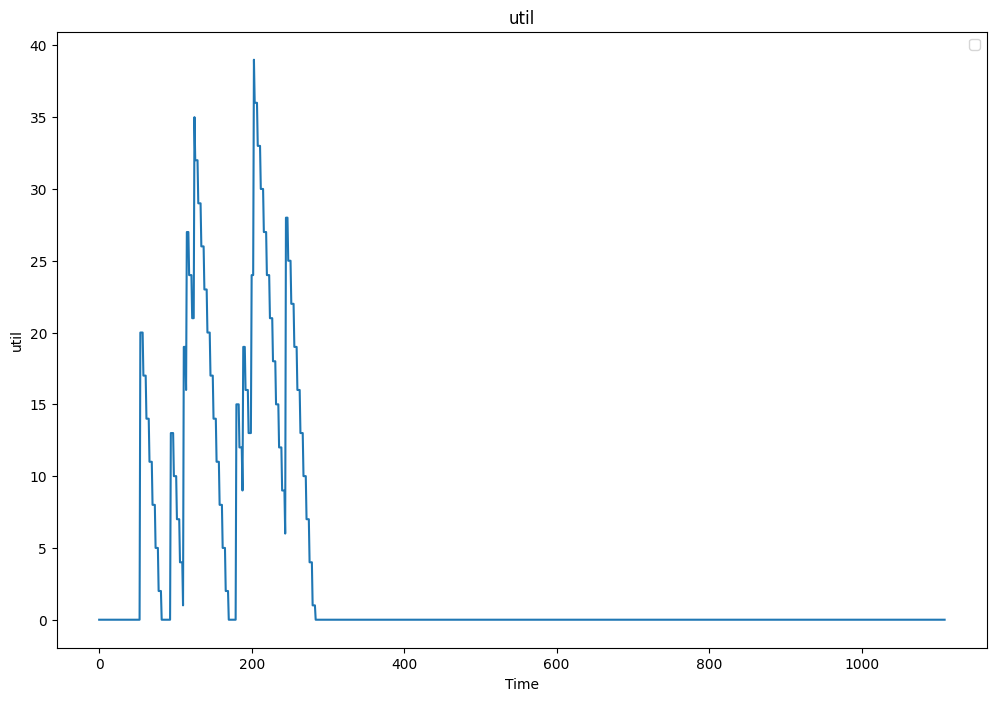

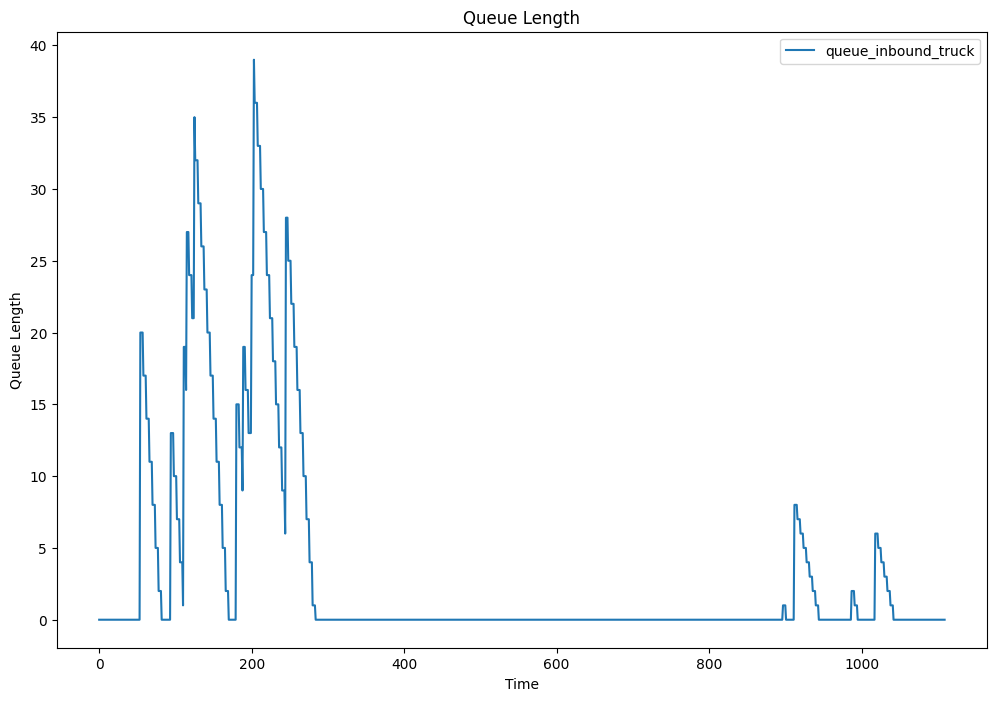

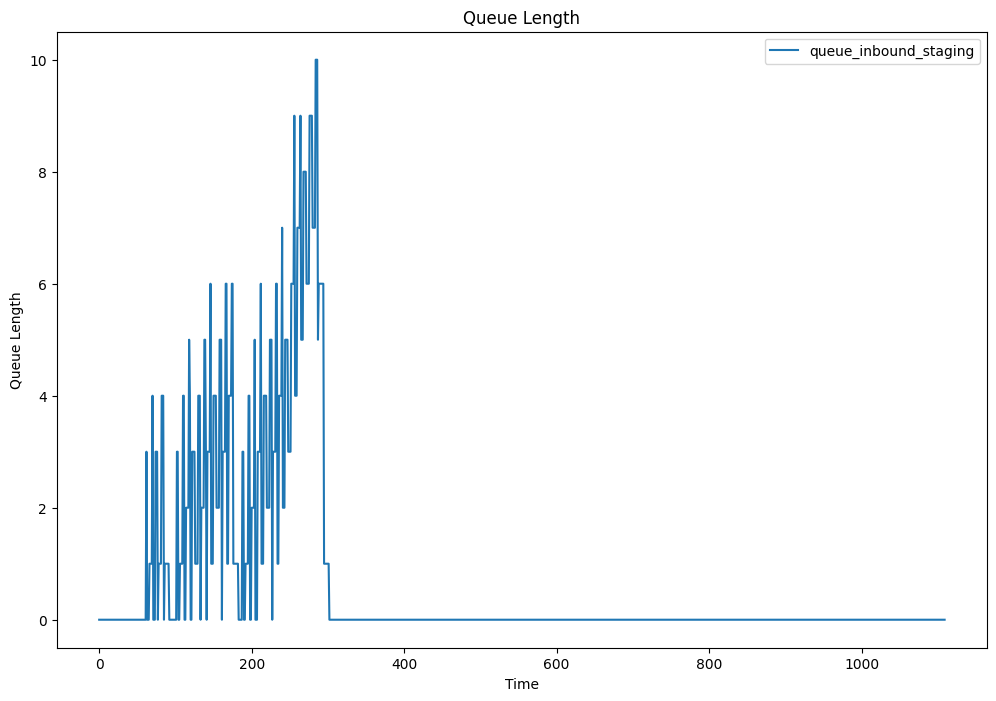

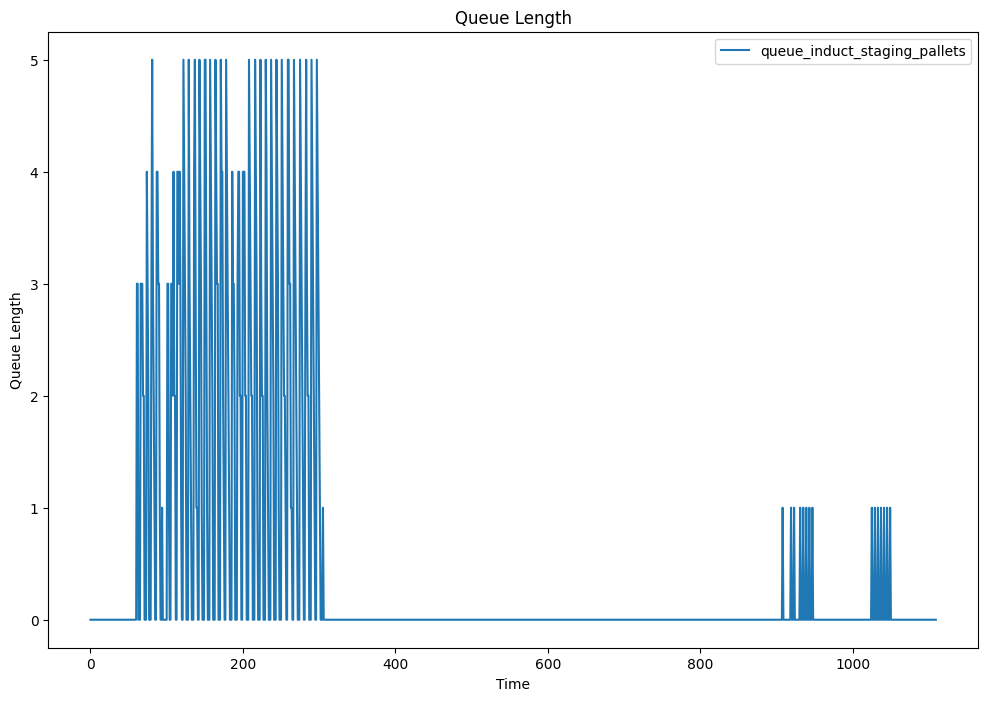

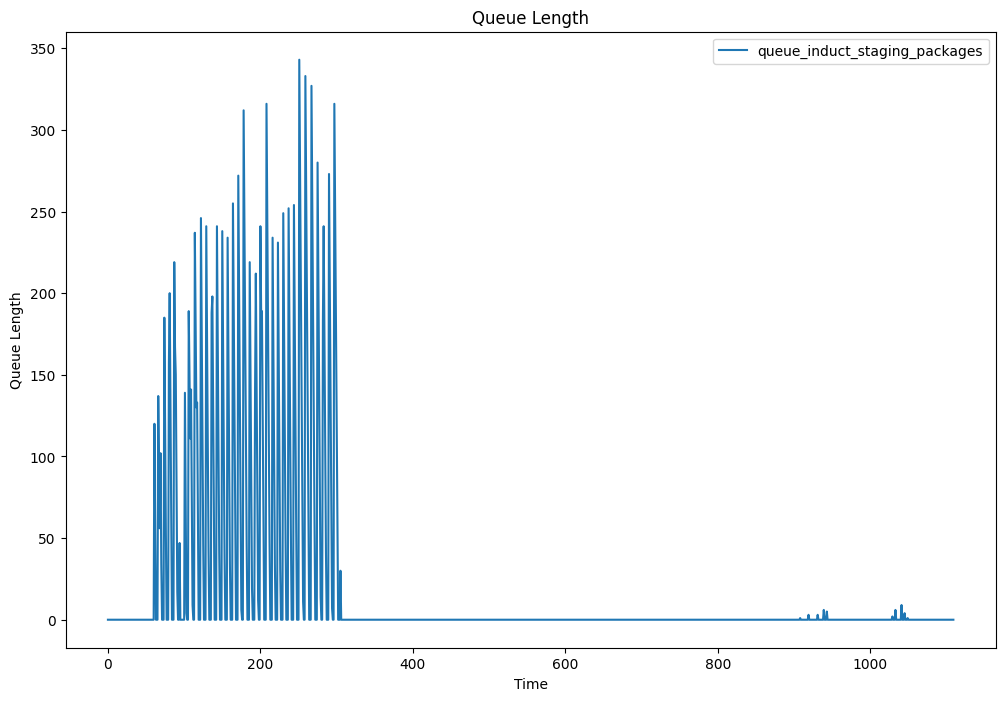

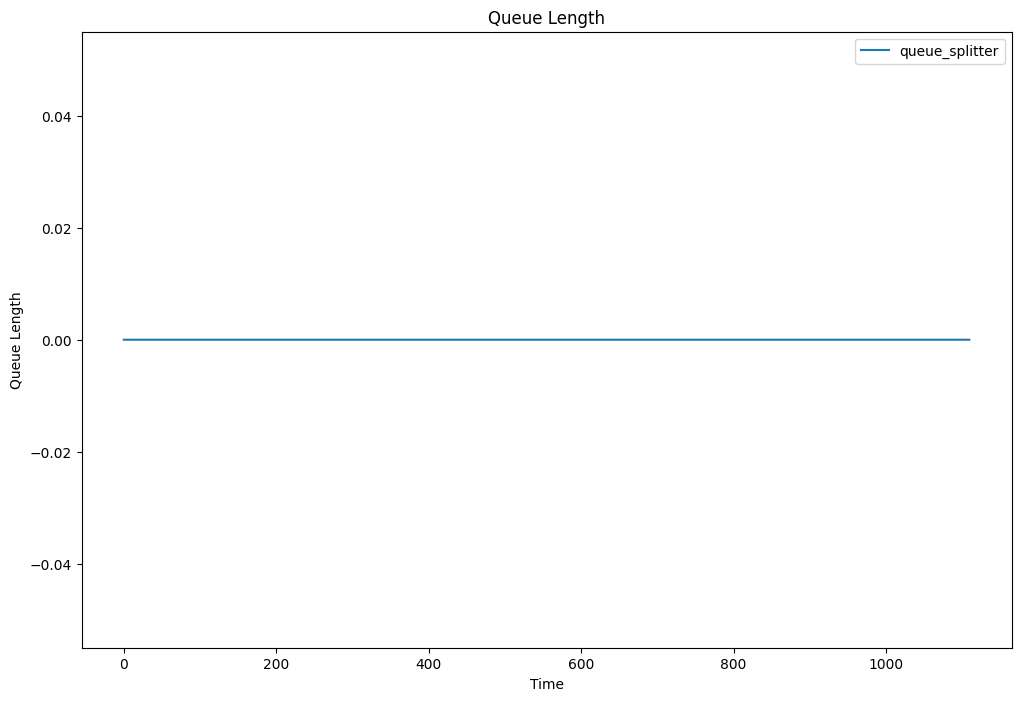

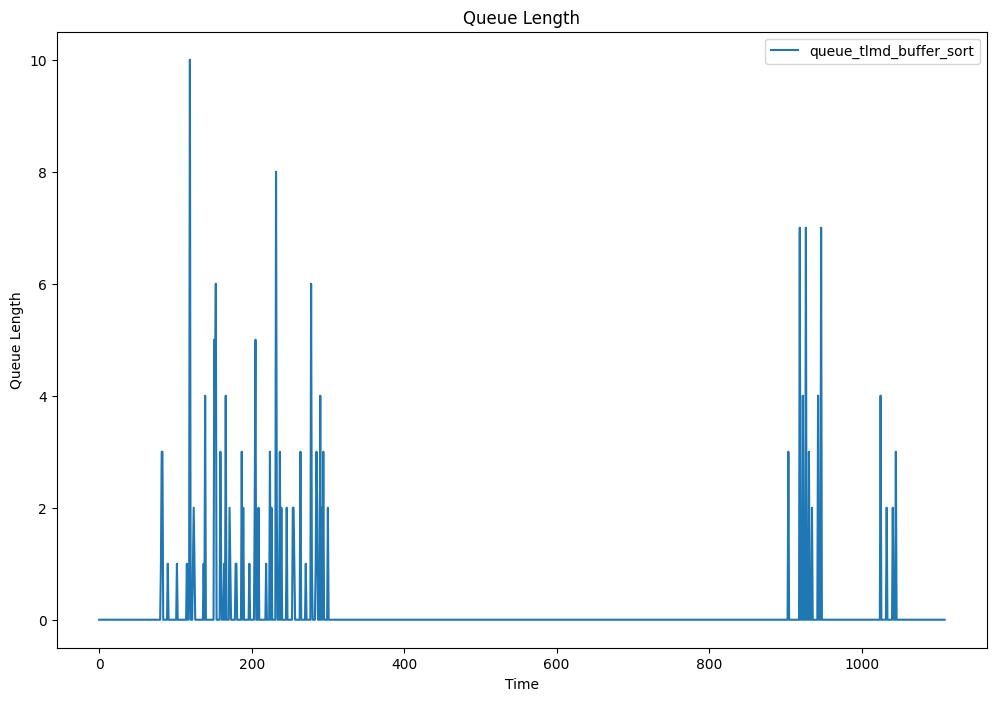

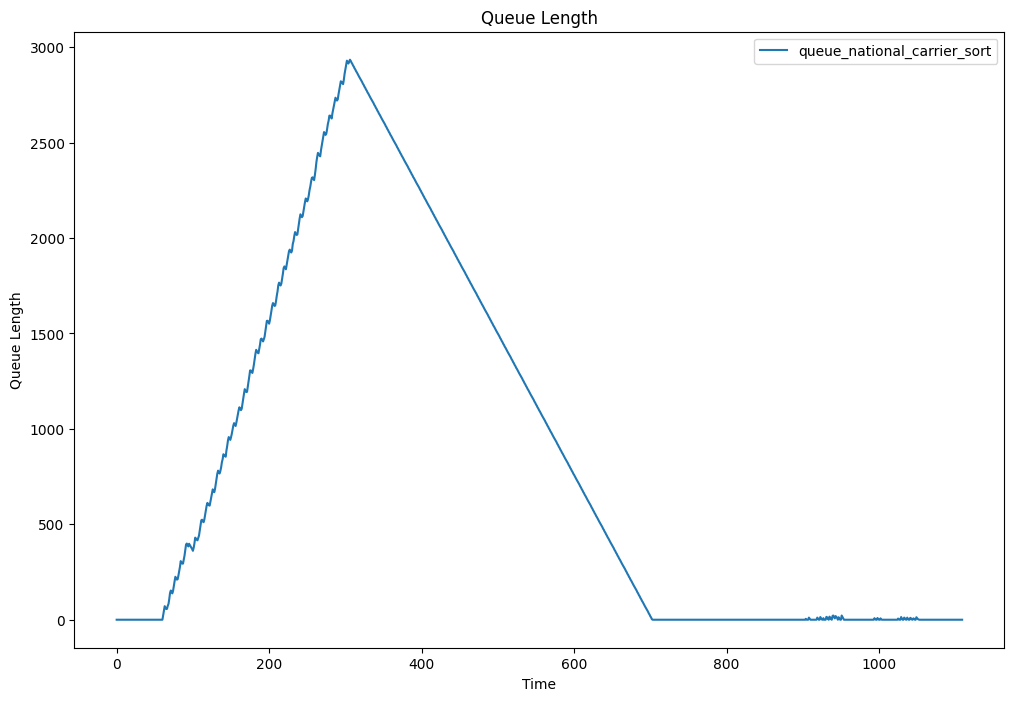

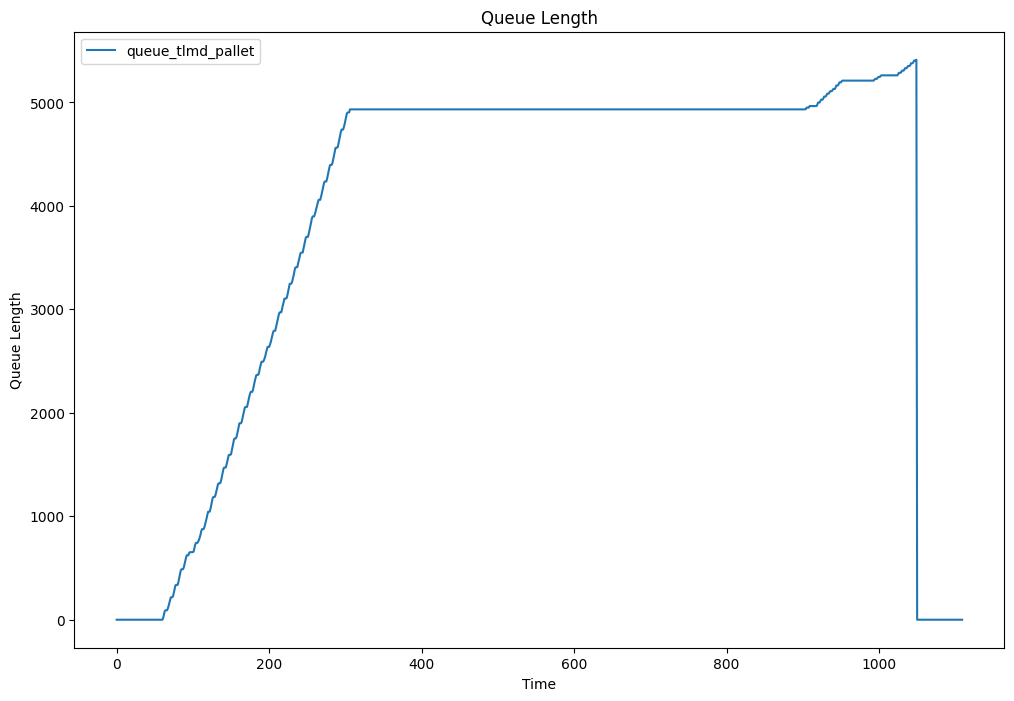

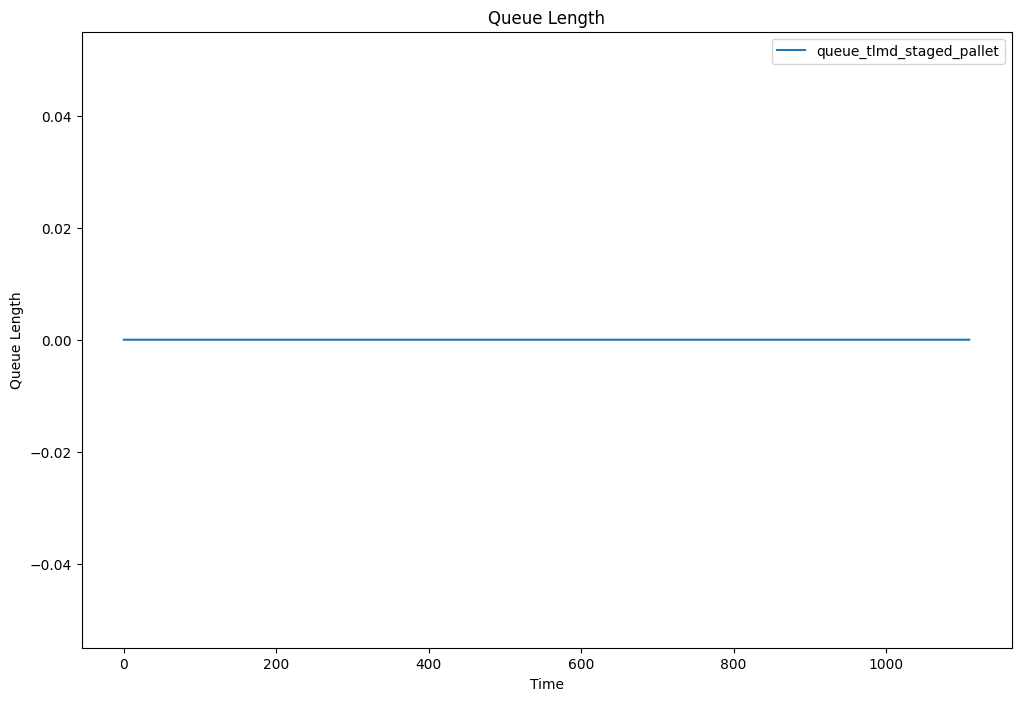

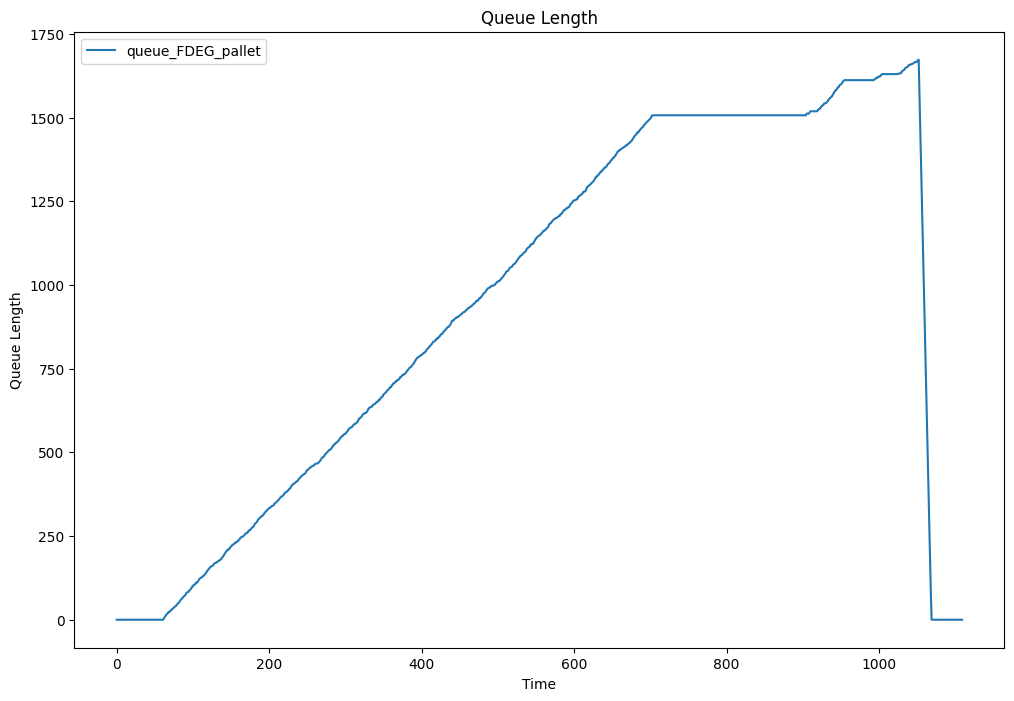

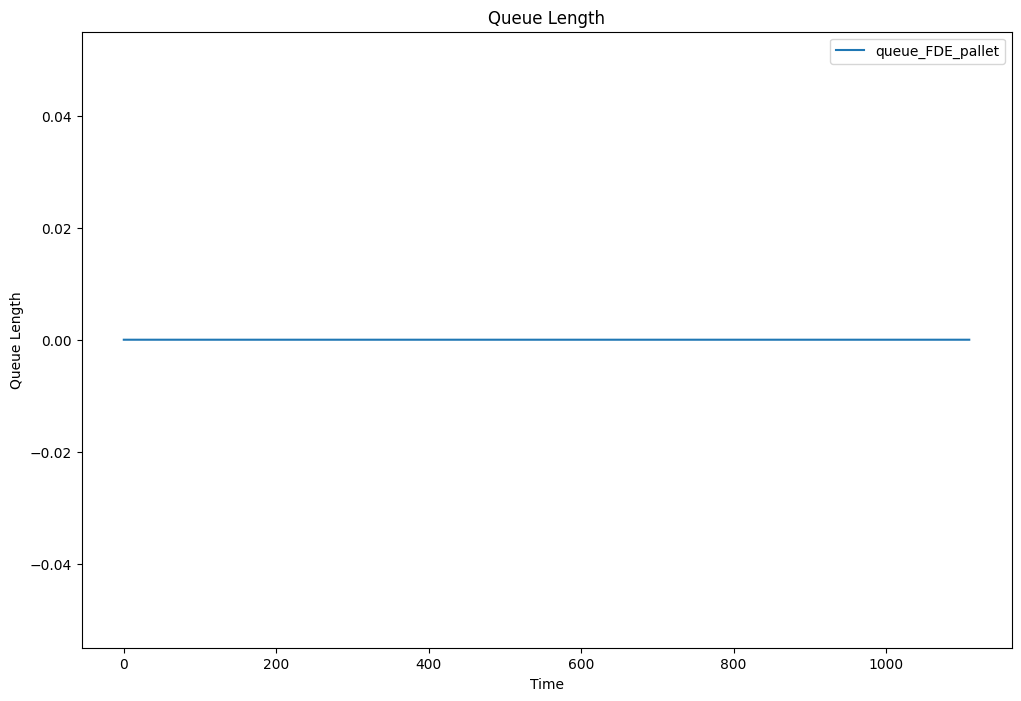

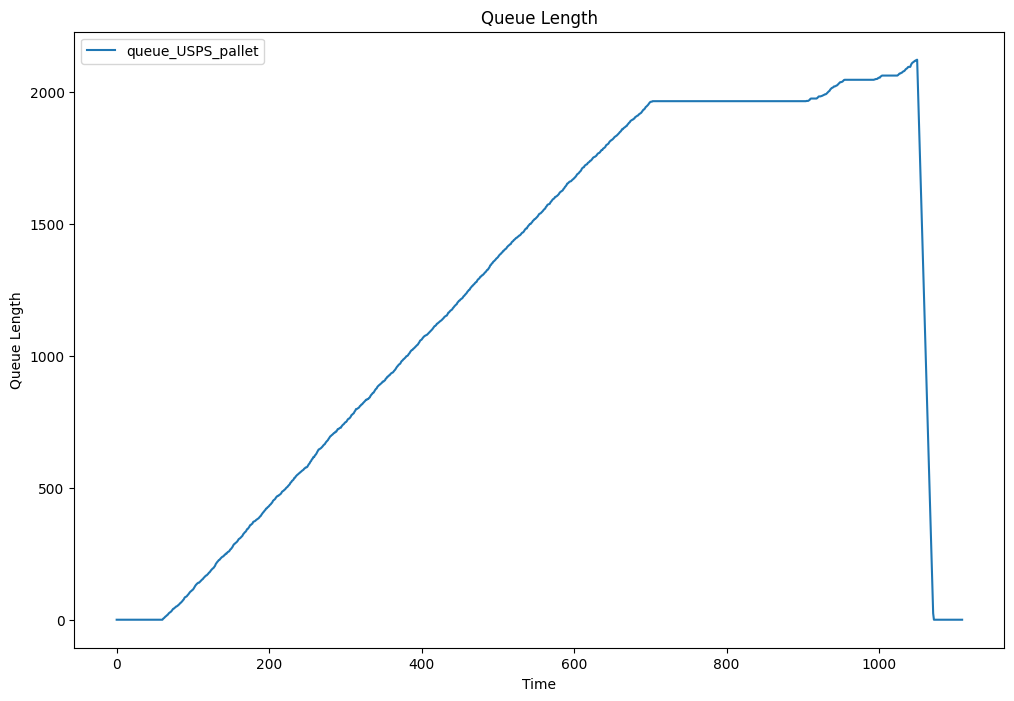

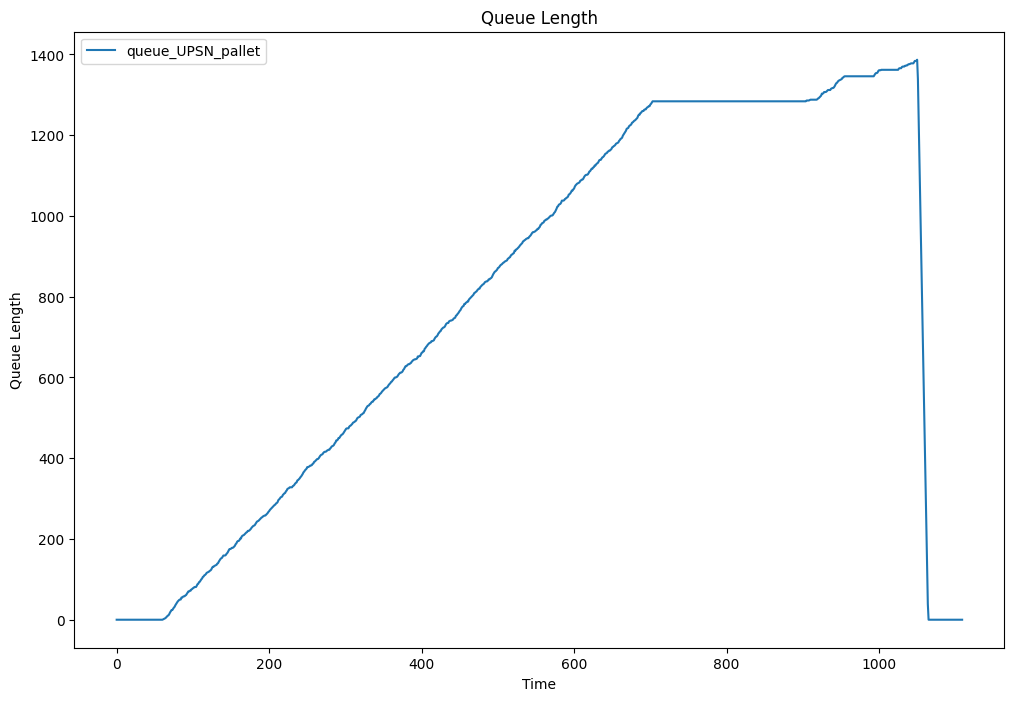

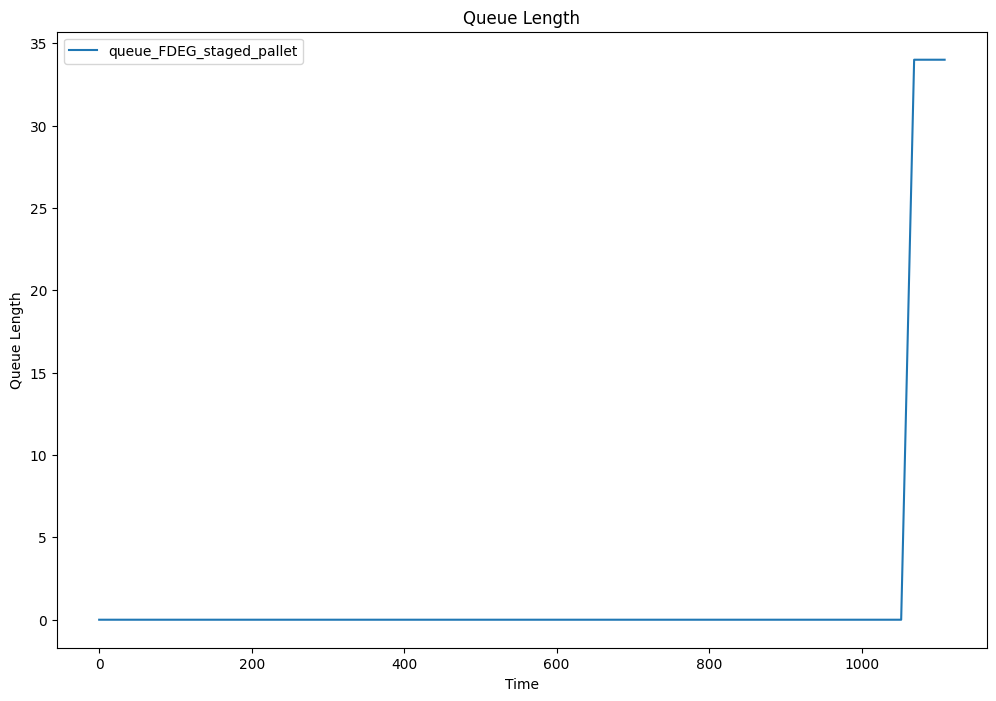

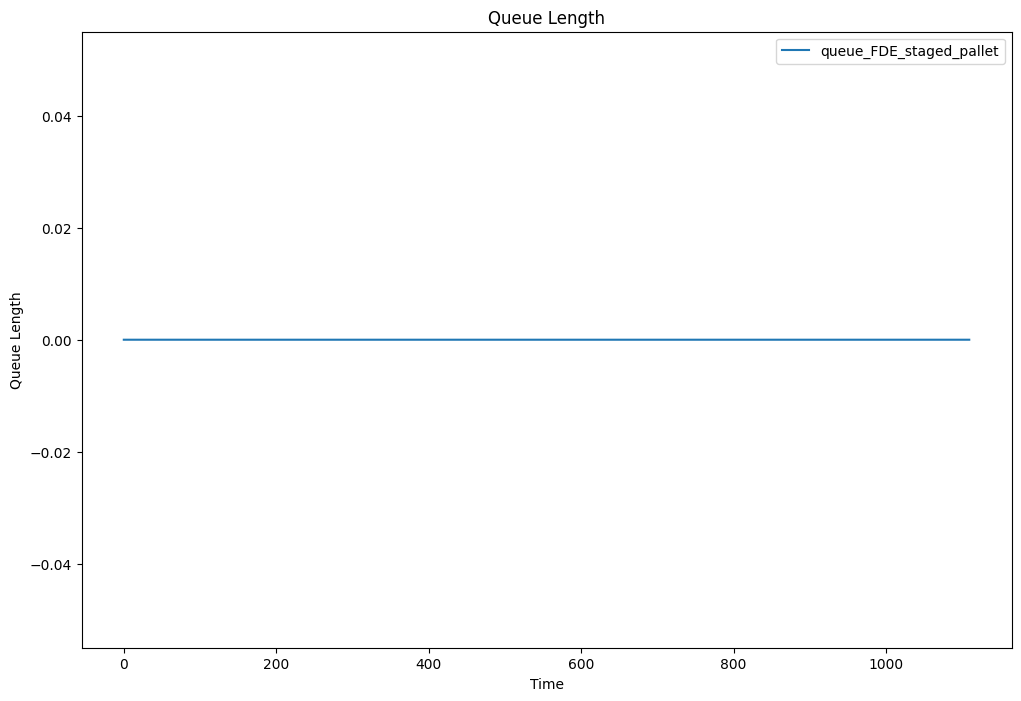

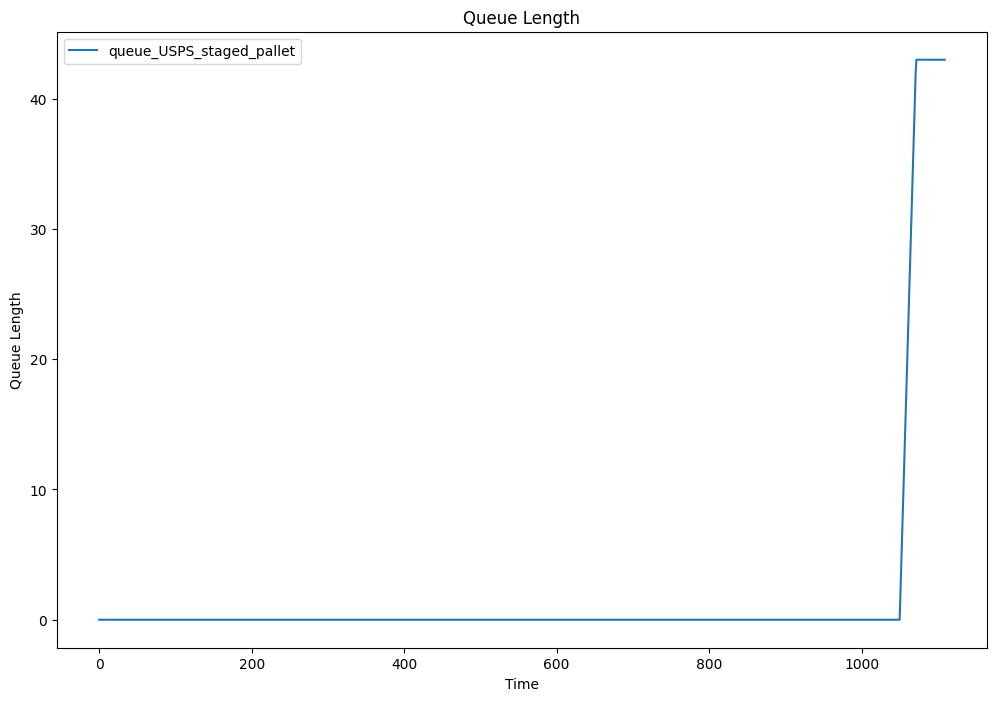

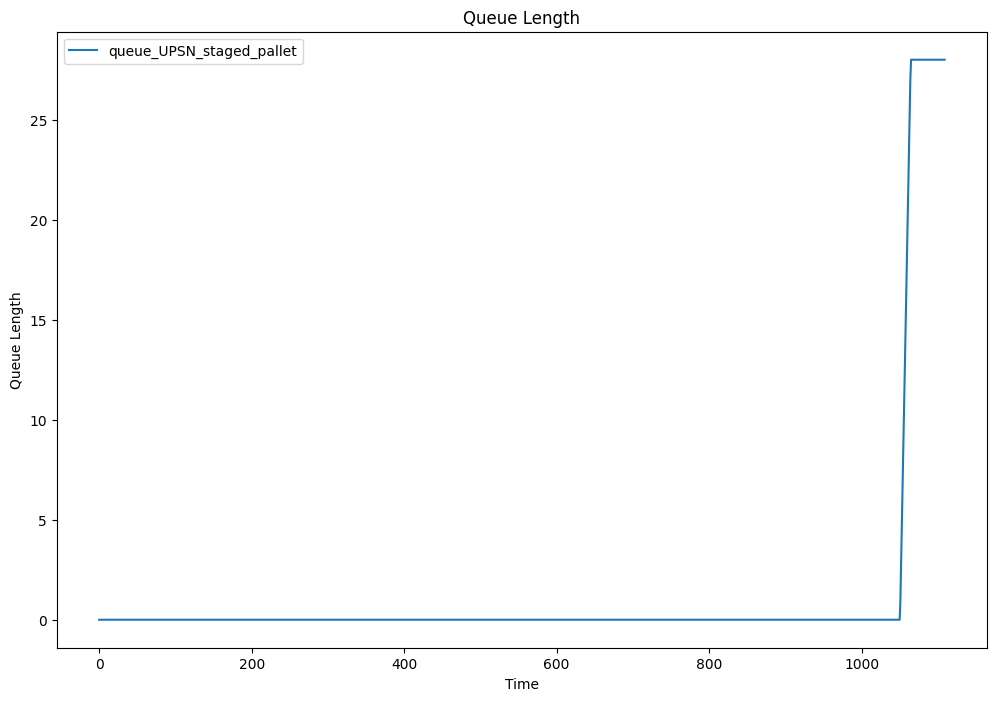

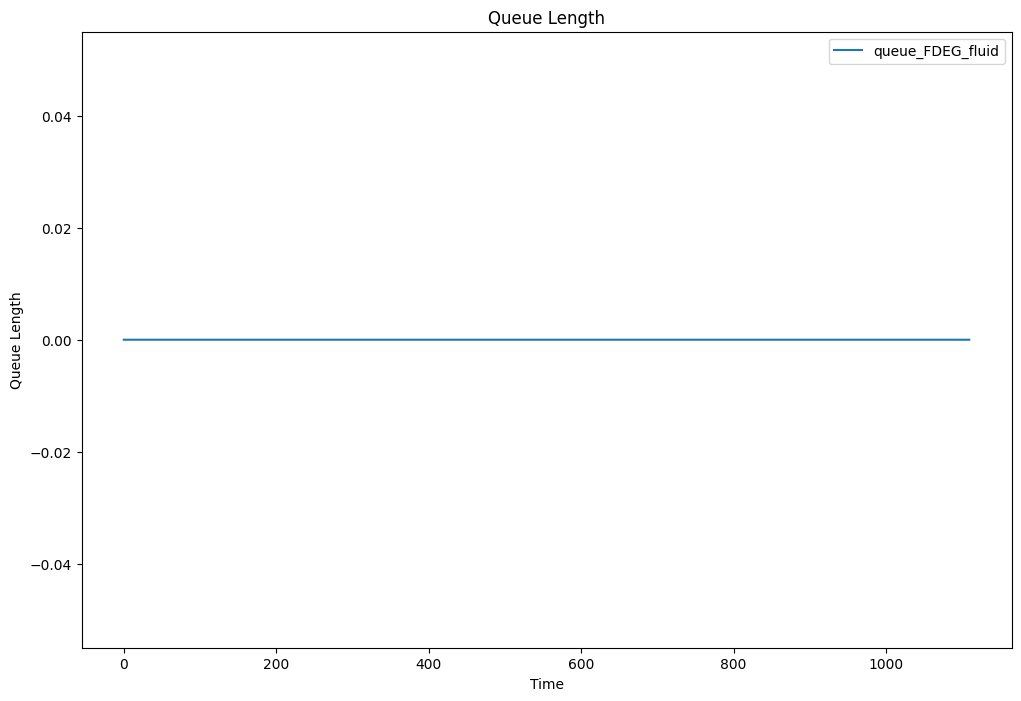

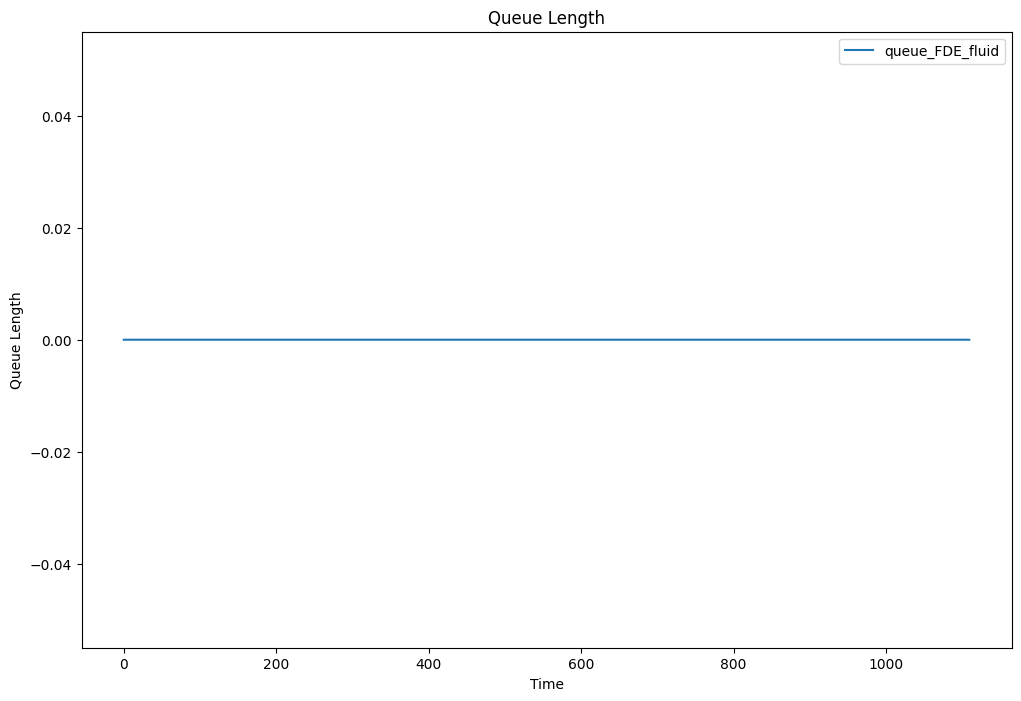

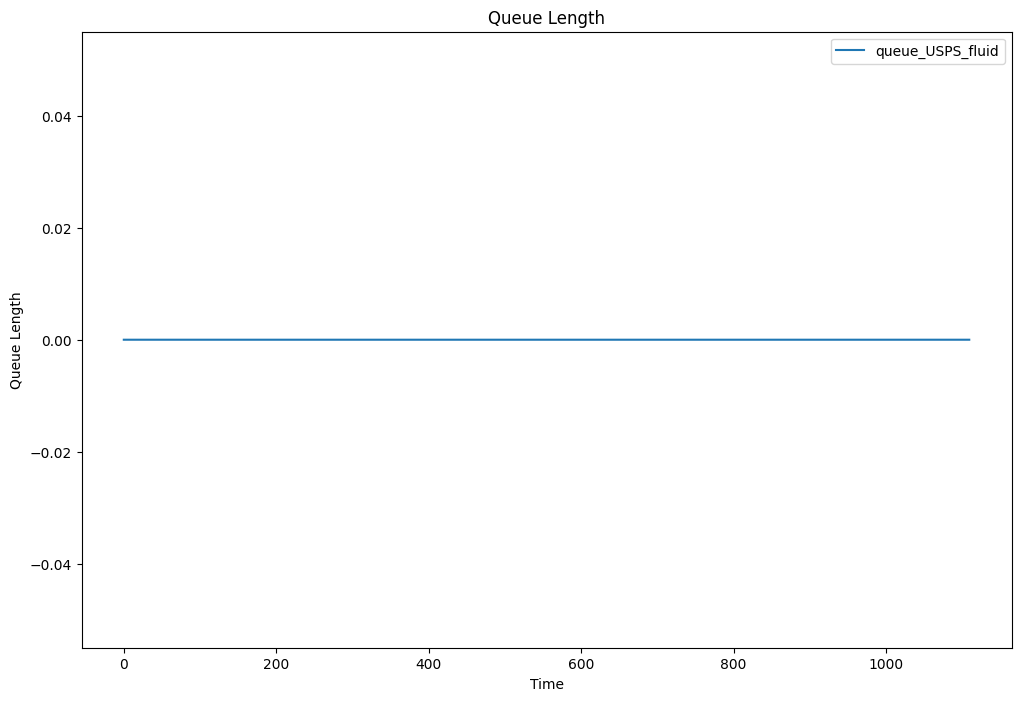

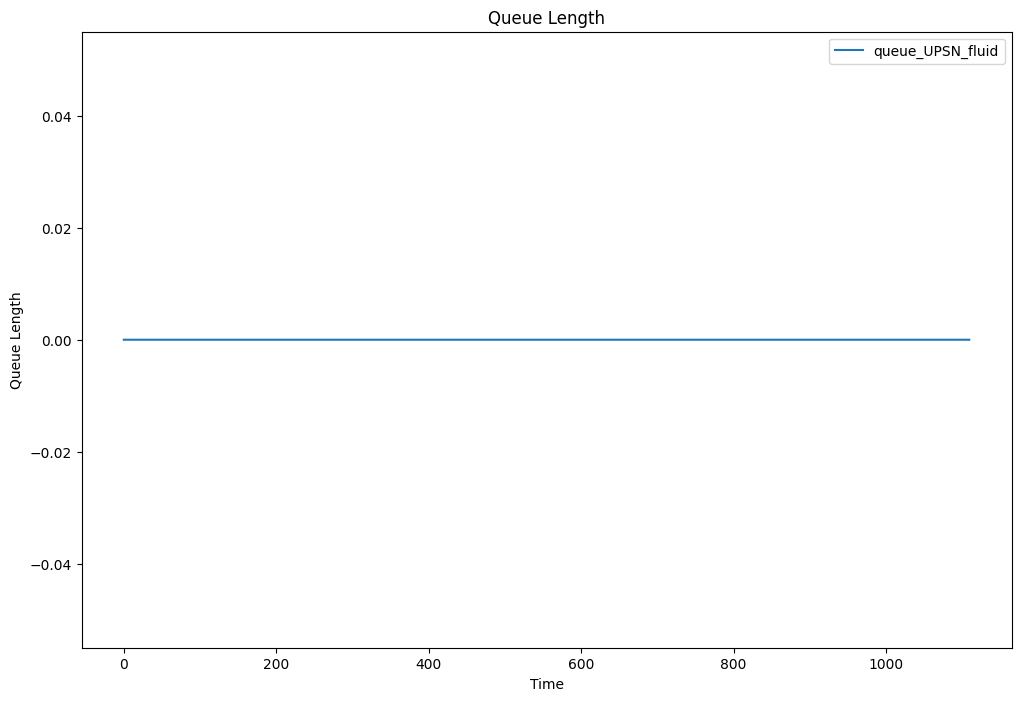

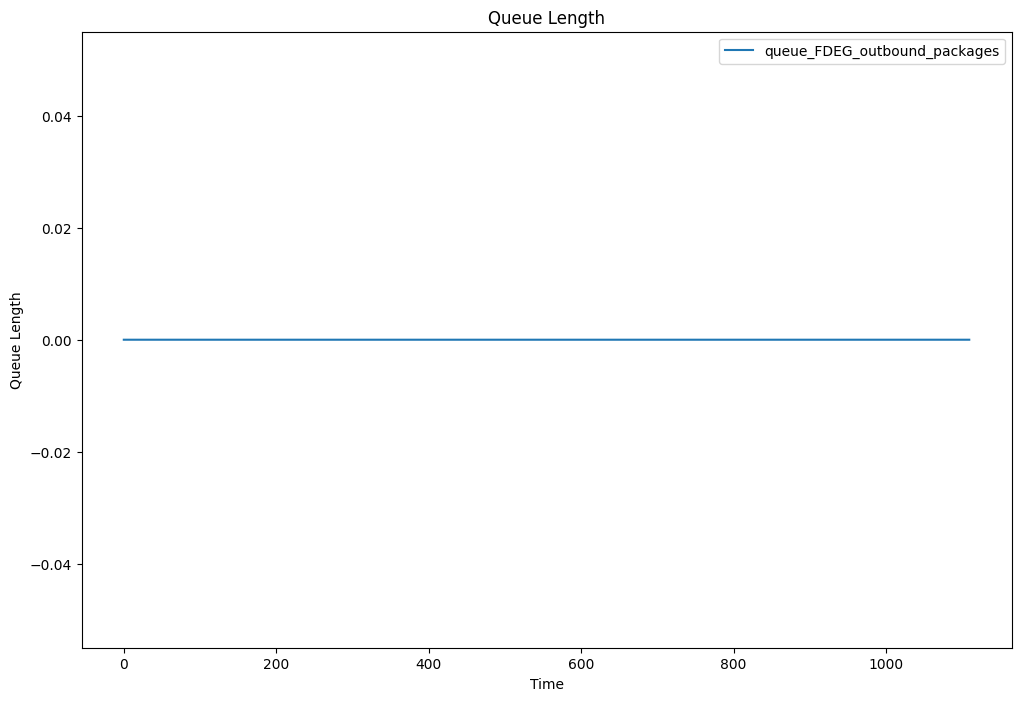

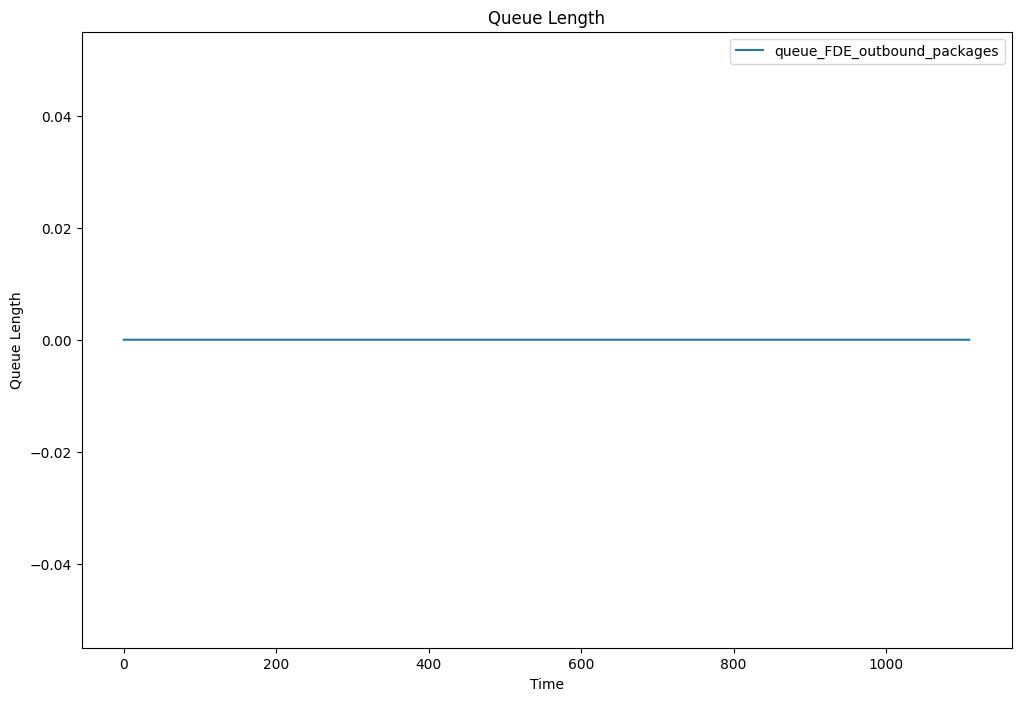

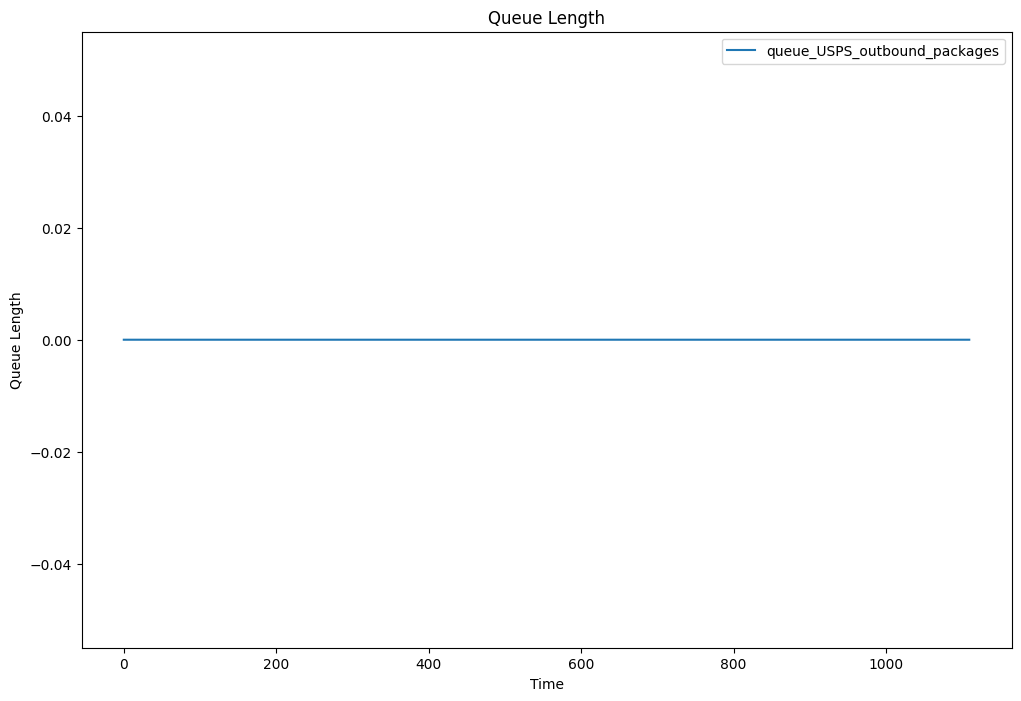

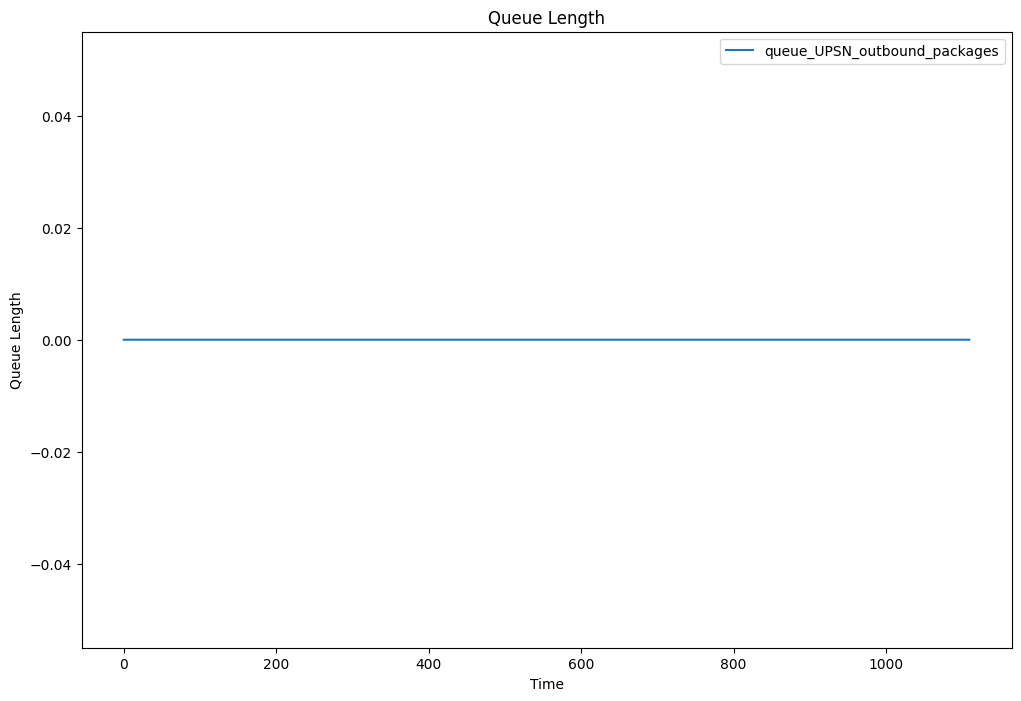

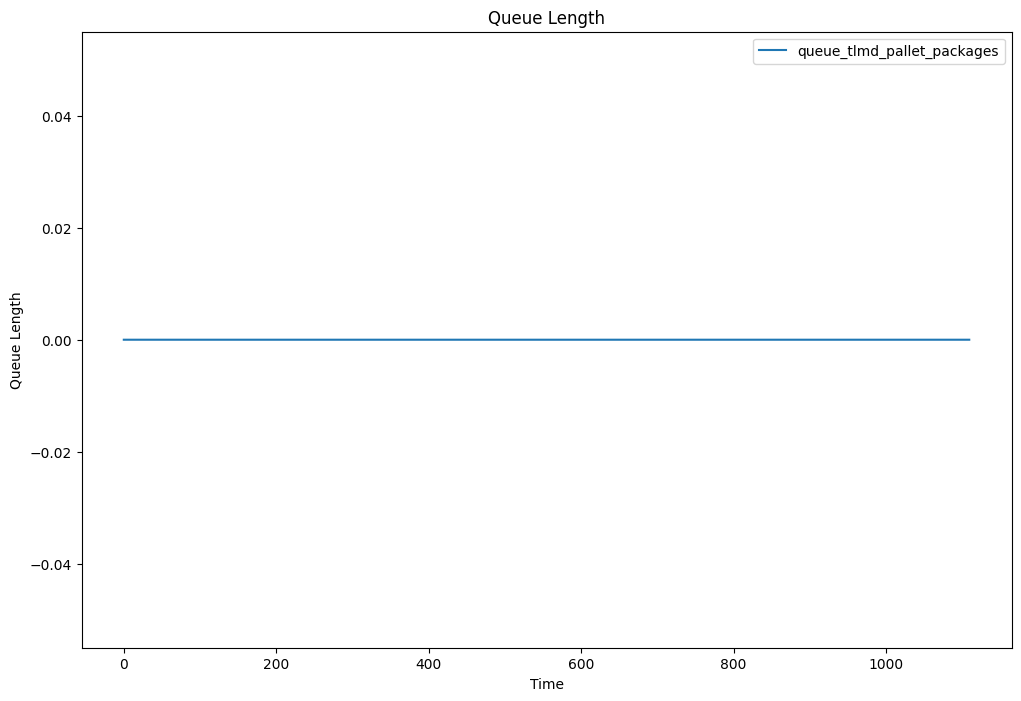

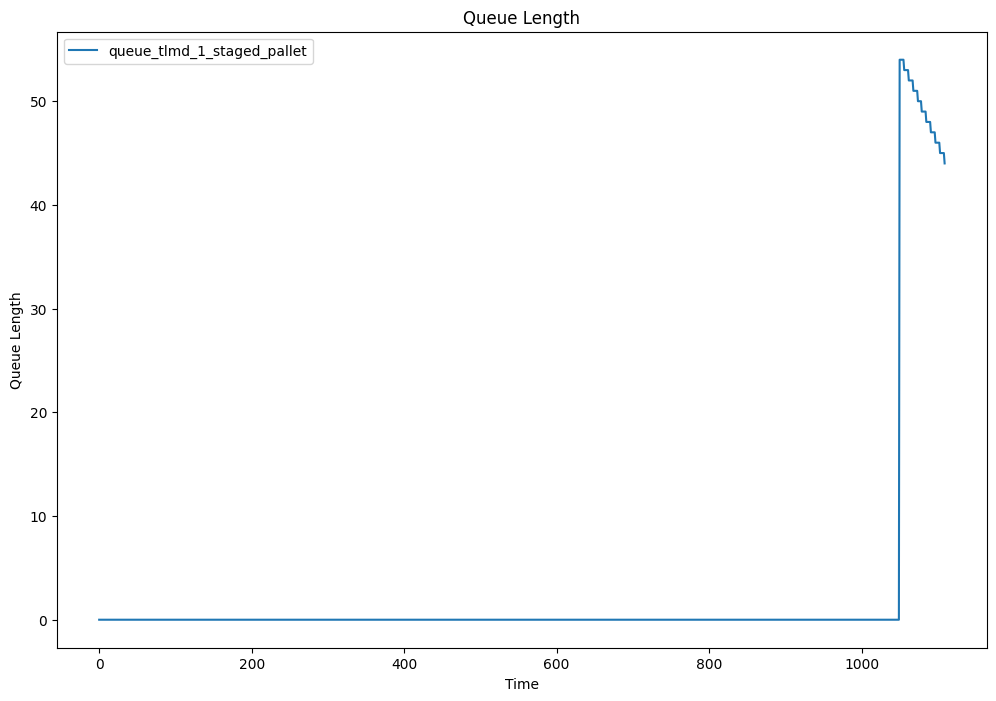

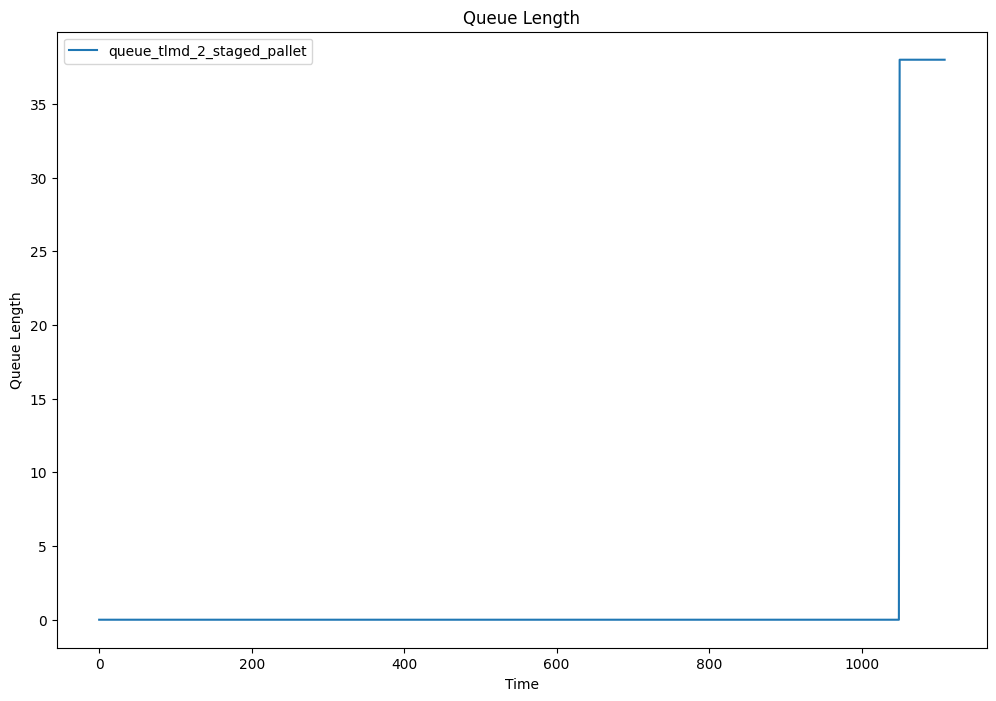

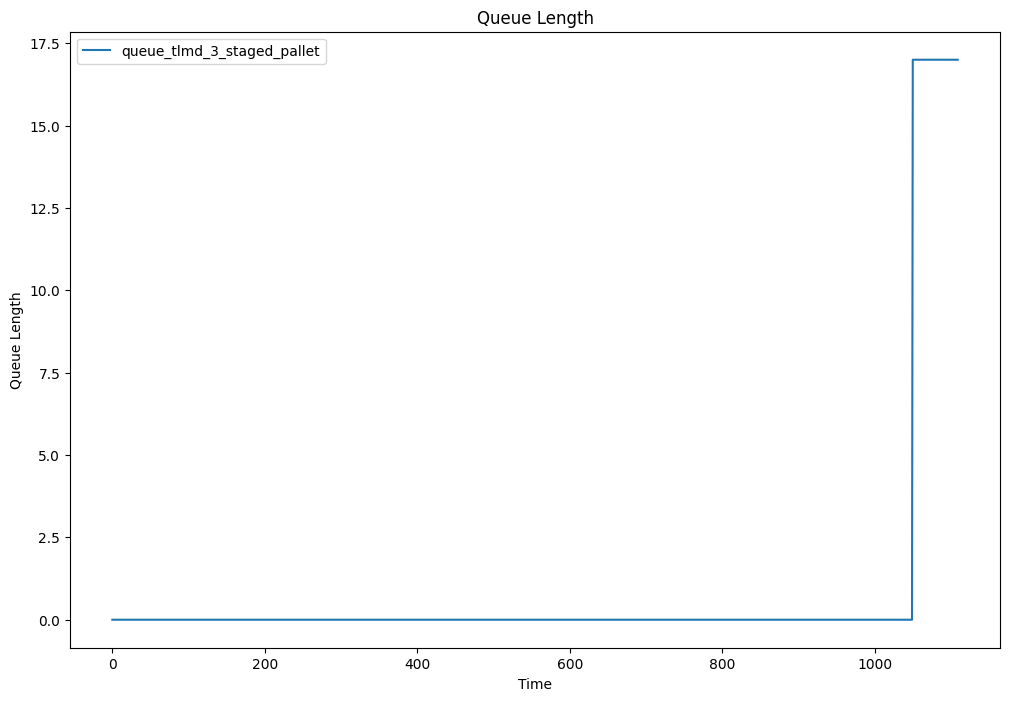

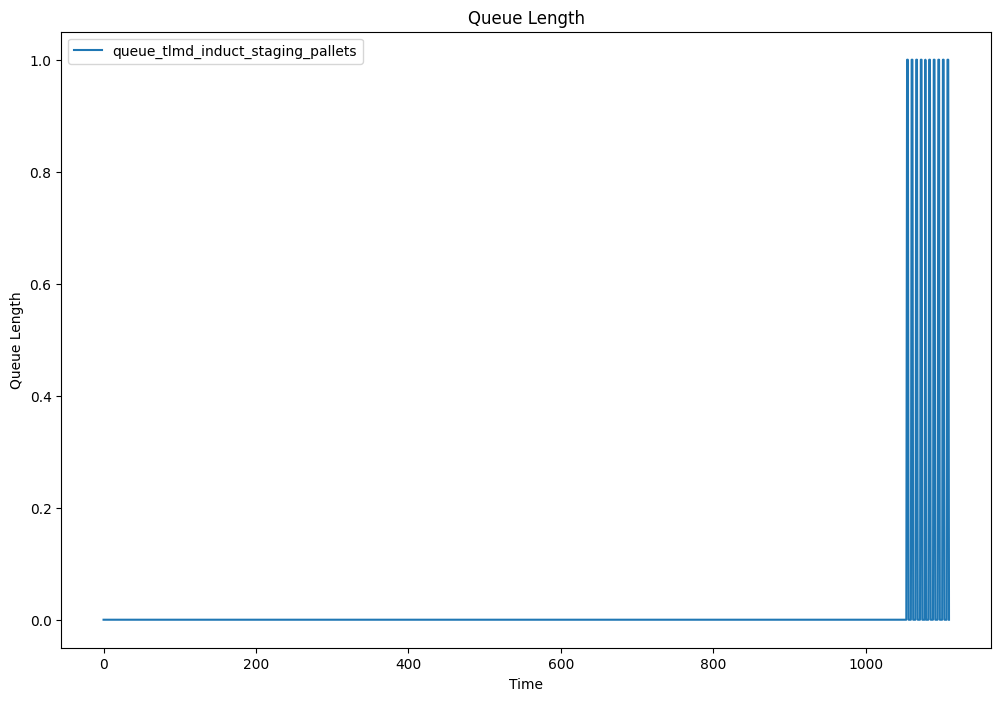

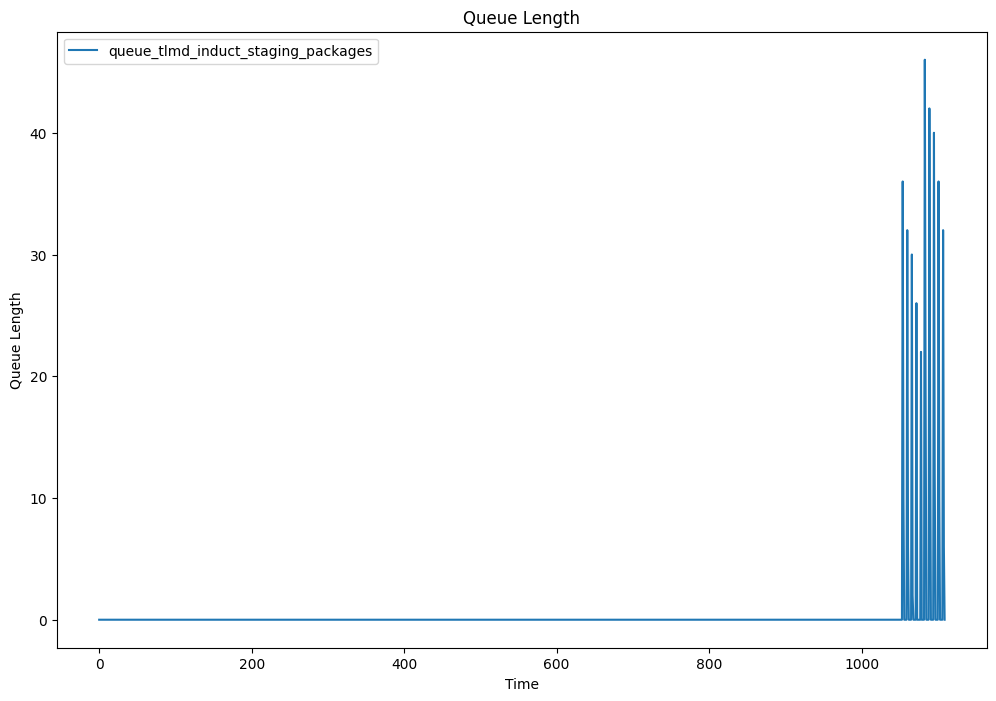

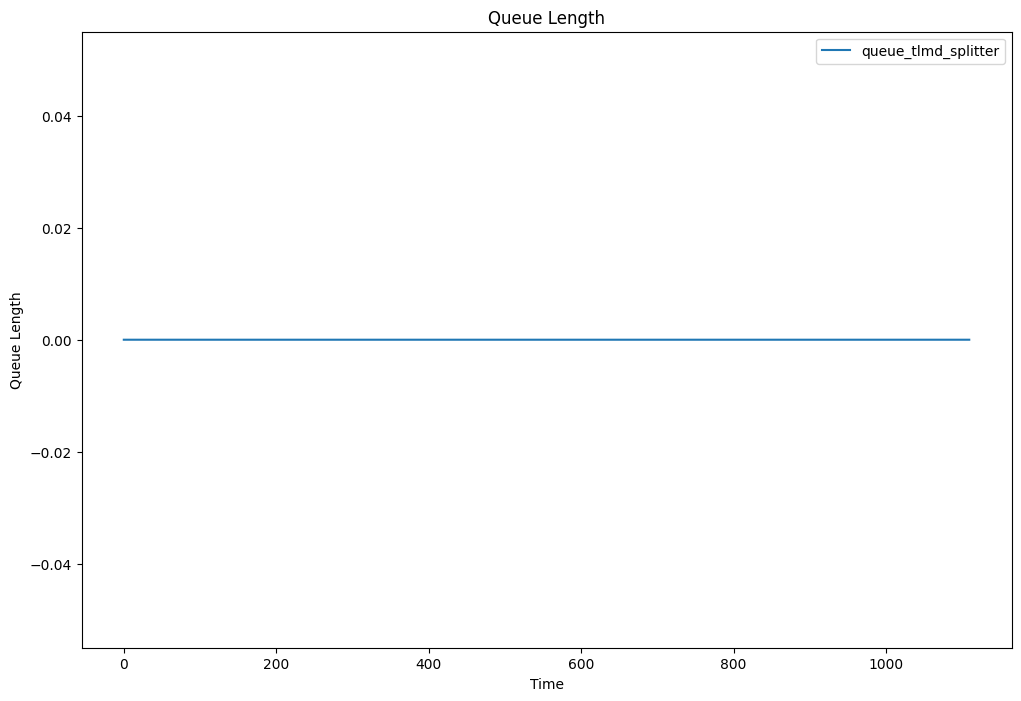

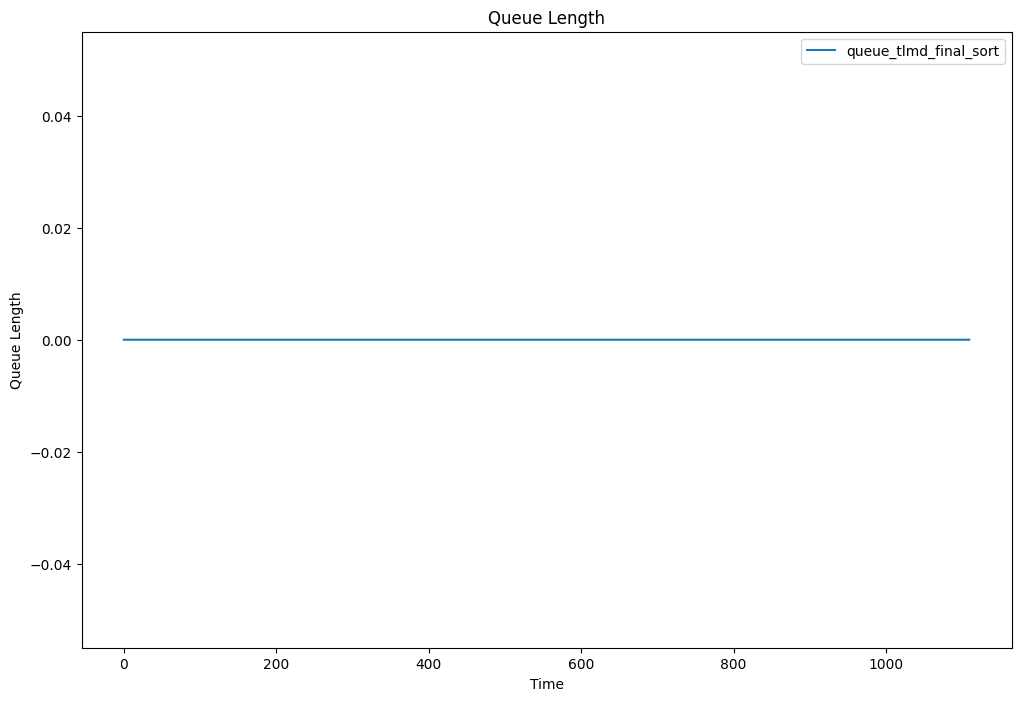

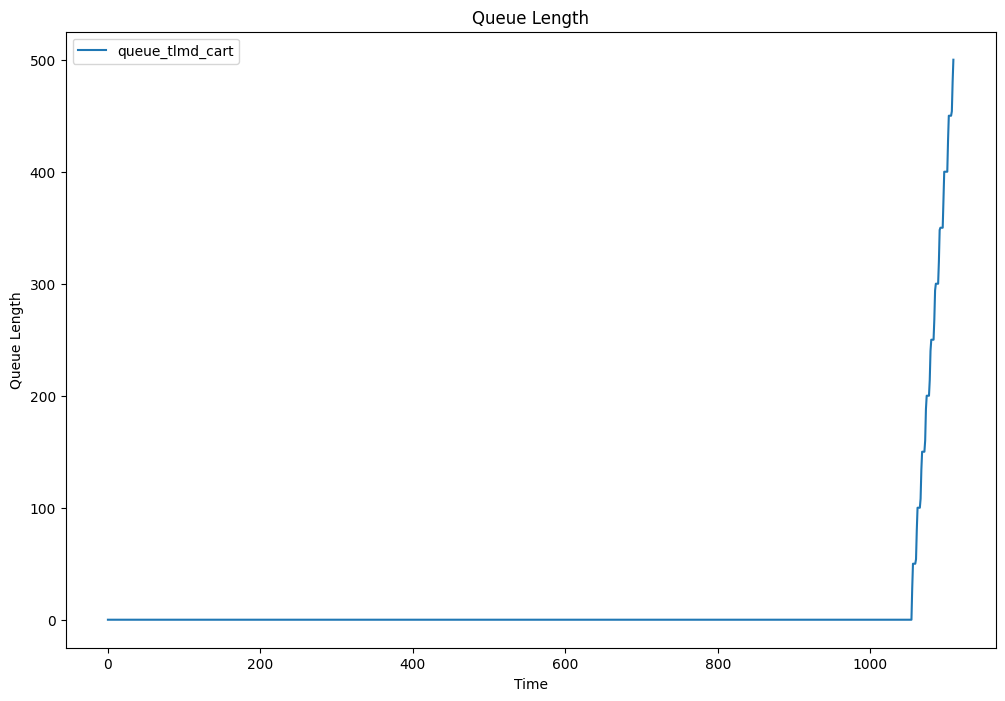

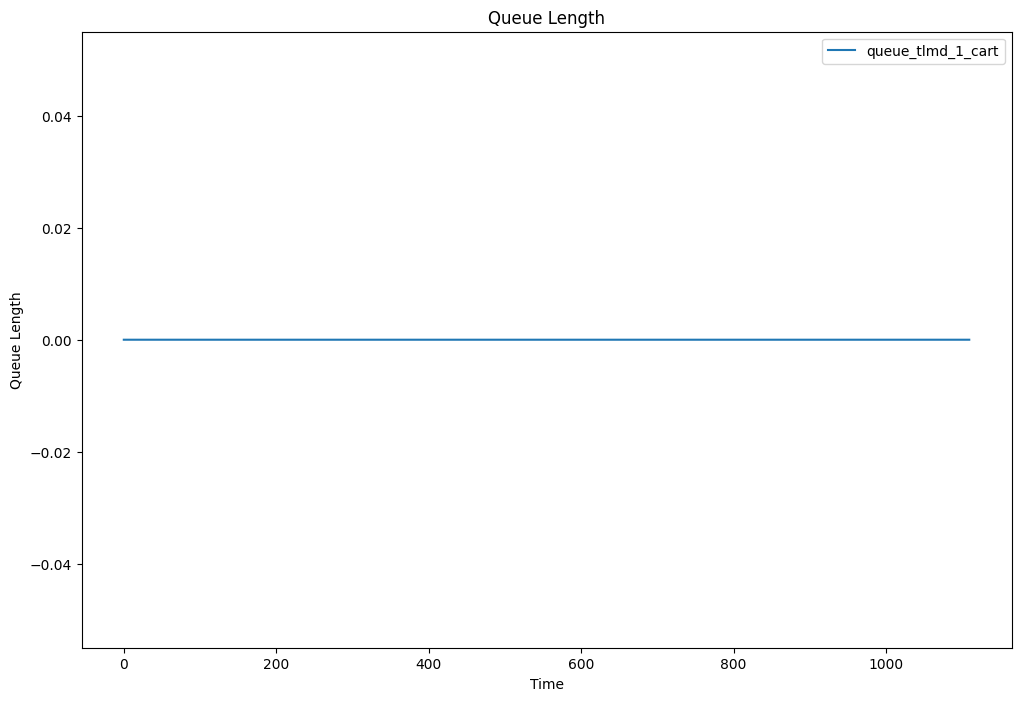

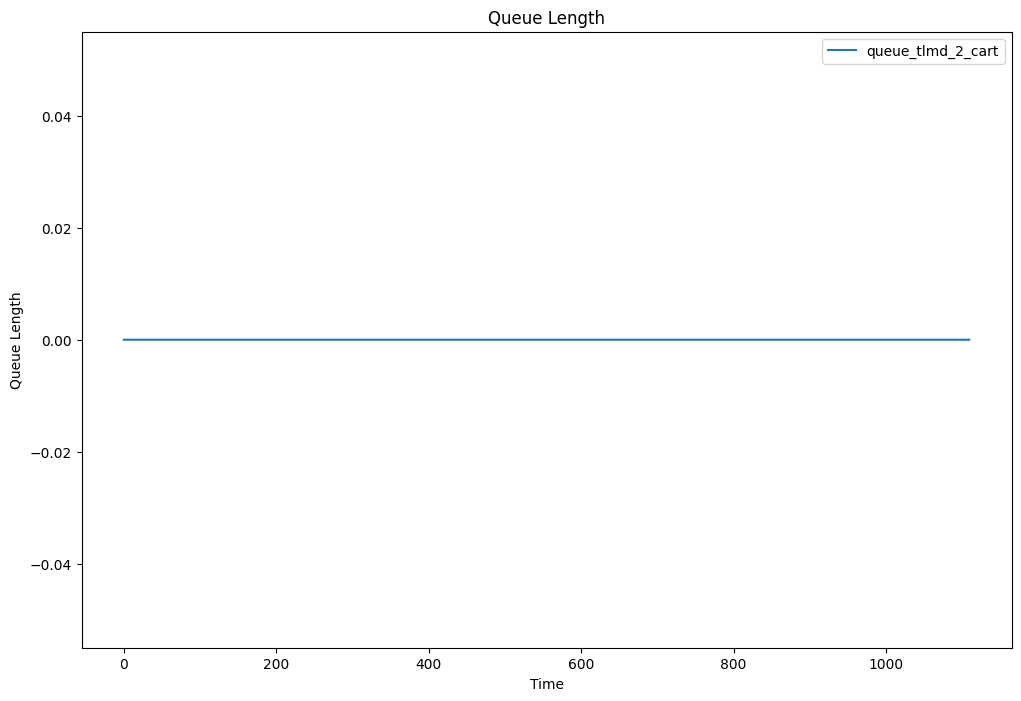

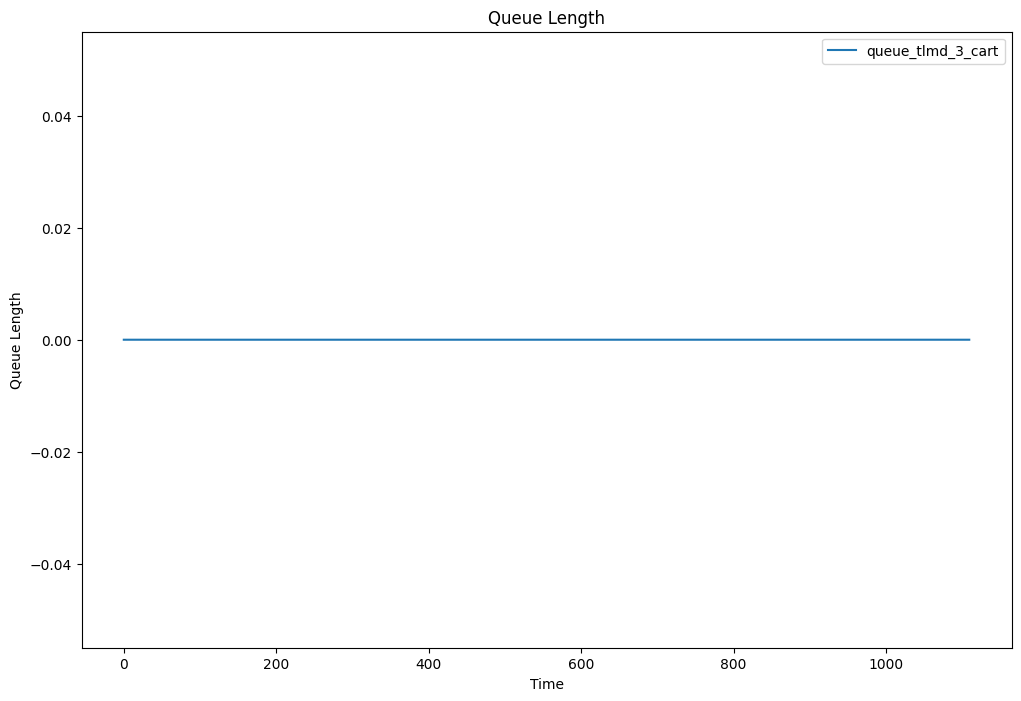

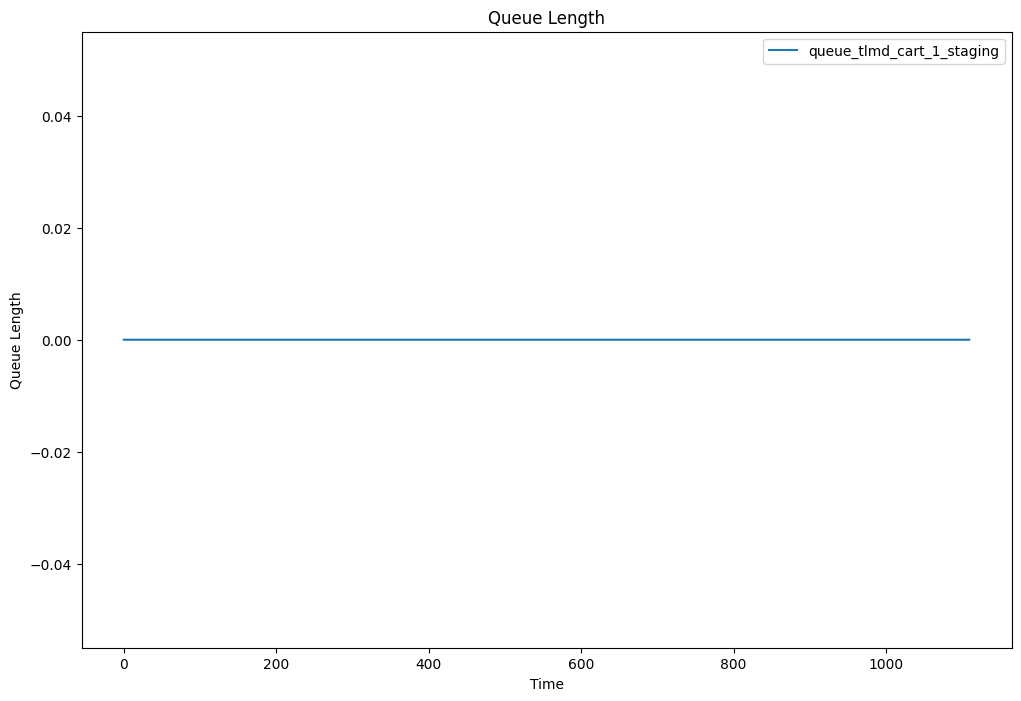

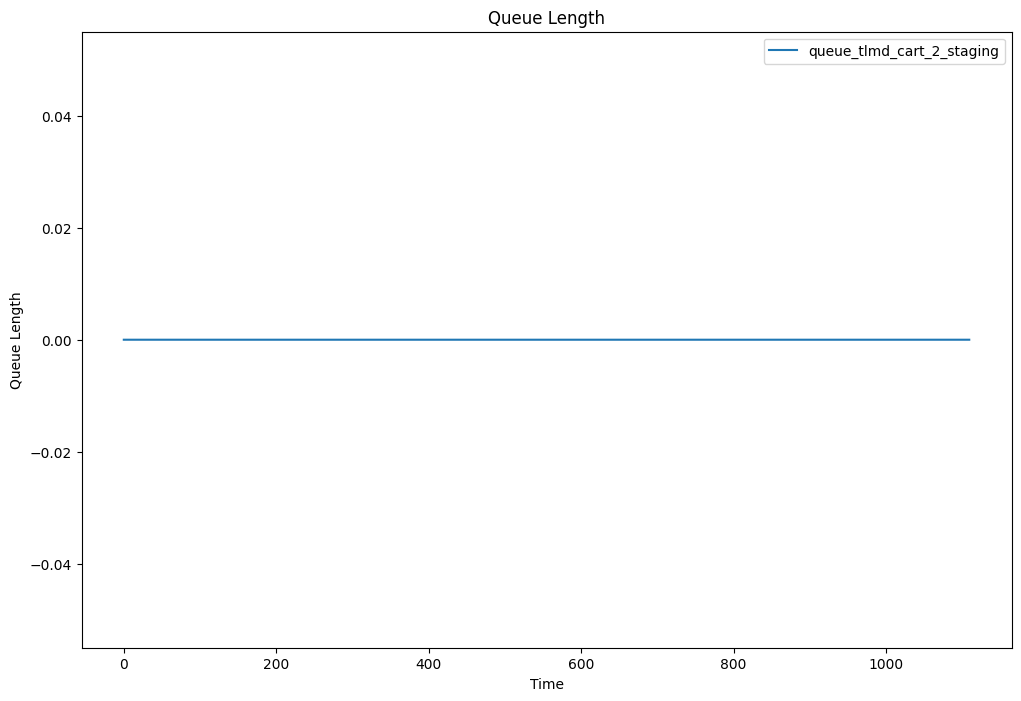

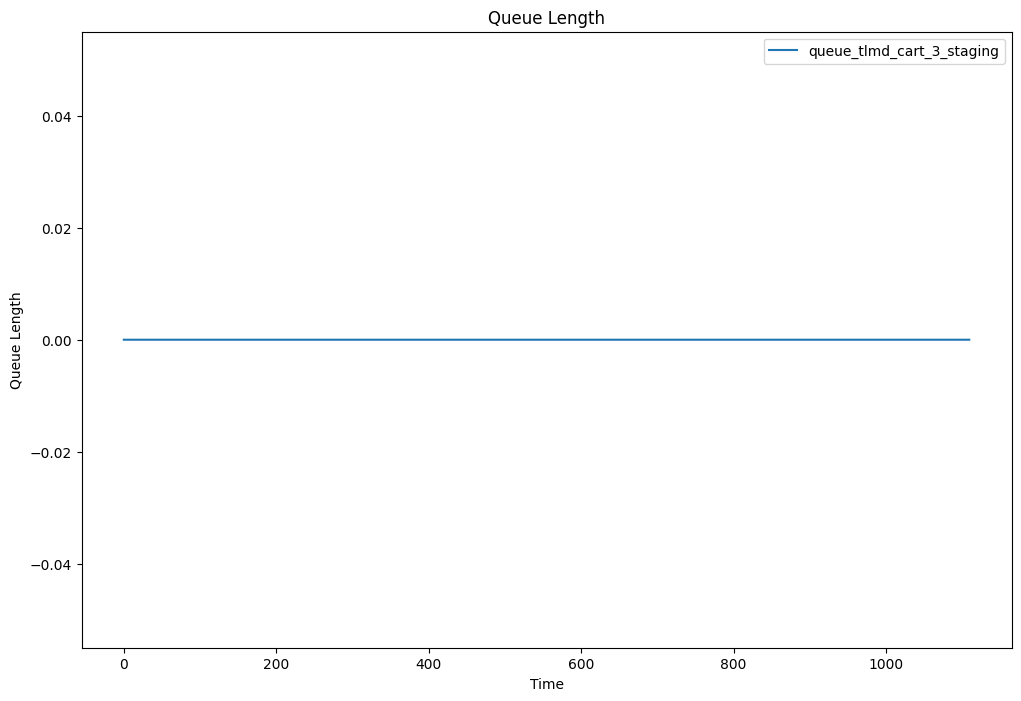

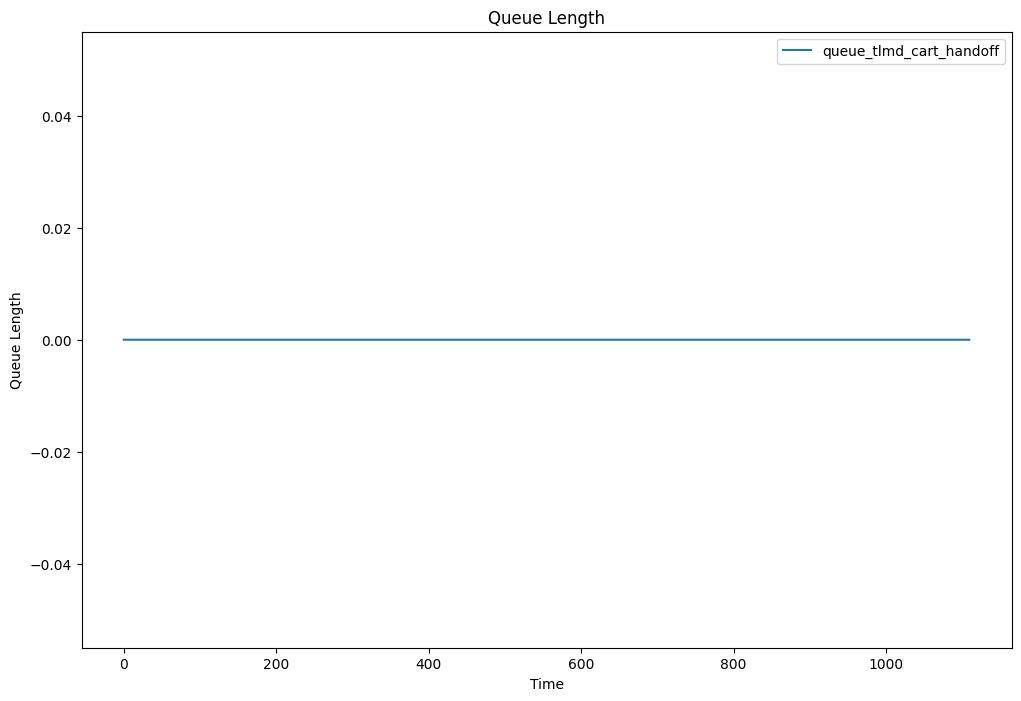

In [4]:
if __name__ == '__main__':
    # Create a sample dataframe for package arrival data
    #csv_path = 'package_arrivals721.csv'
    #df = pd.read_csv(csv_path)
    
    feature_values = {
        'yesterday_total_packages': 16152,
        'RAFT_known_shipped_pkg_count': 5264,
        'RAFT_predicted_carryover_pkg_count': 28,
        'RAFT_predicted_total_handoff_pkg_count': 6594,
        'Day of Week_Sunday': 0,
        'Day of Week_Monday': 1,
        'Day of Week_Tuesday': 0,
        'Day of Week_Wednesday': 0,
        'Day of Week_Thursday': 0,
        'Day of Week_Friday': 0,
        'Day of Week_Saturday': 0,
        'Promotion': 0,
        'TMAX': 36.2,
        'TMIN': 31.8,
        'AWND': 9.87,
        'PRCP': 0.912,
        'SNOW': 6.14
    }

    df_pallets, TFC_vol, TFC_arrival_minutes = sg.simulation_generator(False, feature_values)

    pallet_info = df_pallets.groupby('Pallet').agg(
        num_packages=('package_tracking_number', 'count'),
        earliest_arrival=('pkg_received_utc_ts', 'min'),
        packages=('package_tracking_number', lambda x: list(zip(x, df_pallets.loc[x.index
    , 'scac'])))
    ).reset_index()

    ### Labor Allocations ###
    night_total_tm = 27

    night_tm_pit_unload = 3 
    night_tm_pit_induct = 5
    night_tm_nonpit_split = 1  # must be 1
    night_tm_nonpit_NC = 3
    night_tm_nonpit_buffer = 15

    #NIGHTS TLMD SORT ALLOCATION
    night_tm_TLMD_induct = 6
    night_tm_TLMD_picker = 4  #Must be 4
    night_tm_TLMD_sort = 17

    #NIGHTS TLMD STAGE ALLOCATION
    night_tm_TLMD_stage = 27
    night_tm_TLMD_handoff = 27

    day_total_tm = 19

    #DAYS INBOUND INDUCT ALLOCATION
    day_tm_pit_unload = 1 
    day_tm_pit_induct = 4
    day_tm_nonpit_split = 1   # must be 1
    day_tm_nonpit_NC = 3
    day_tm_nonpit_buffer = 10

    #NIGHTS TLMD SORT ALLOCATION
    day_tm_TLMD_induct = 2  
    day_tm_TLMD_picker = 4  #Must be 4
    day_tm_TLMD_sort = 13
    

    #NIGHTS TLMD STAGE ALLOCATION
    day_tm_TLMD_stage = 19
    day_tm_TLMD_handoff = 19

    if night_tm_pit_unload + night_tm_pit_induct + night_tm_nonpit_split + night_tm_nonpit_NC + night_tm_nonpit_buffer > night_total_tm:
        raise ValueError('Total number of TMs exceeds the limit')   
    
    if night_tm_TLMD_induct + night_tm_TLMD_picker + night_tm_TLMD_sort  >  night_total_tm:
        raise ValueError('Total number of TMs exceeds the limit')

    if night_tm_TLMD_stage > night_total_tm or night_tm_TLMD_handoff > night_total_tm:
        raise ValueError('Total number of TMs exceeds the limit')
    
    
    if day_tm_pit_unload + day_tm_pit_induct + day_tm_nonpit_split + day_tm_nonpit_NC + day_tm_nonpit_buffer > day_total_tm:
        raise ValueError('Total number of TMs exceeds the limit')   
    
    if day_tm_TLMD_induct + day_tm_TLMD_picker + day_tm_TLMD_sort  >  day_total_tm:
        raise ValueError('Total number of TMs exceeds the limit')

    if day_tm_TLMD_stage > day_total_tm or day_tm_TLMD_handoff > day_total_tm:
        raise ValueError('Total number of TMs exceeds the limit')
    
    unavailable_periods = [
        # (180, 210),  # Night shift bk1
        # (420, 435),  # Night shift bk2
        # (800, 810),  # Night shift shift gap
        # (990, 1020),  # Day shift break 1
        # (1230, 1245),  # Day shift break 2
        # (1410, 1440)  # Day shift shift gap
    ]

    night_shift_period = [
        (0, 700)
    ]

    day_shift_period = [
        (700, 1110)
    ]

    # Setup inbound induct simulation
    env, sortation_center = setup_simulation(pallet_info, 
                                             night_tm_pit_unload, 
                                             night_tm_pit_induct, 
                                             night_tm_nonpit_split, 
                                             night_tm_nonpit_NC, 
                                             night_tm_nonpit_buffer,
                                             night_tm_TLMD_induct,
                                             night_tm_TLMD_picker,
                                             night_tm_TLMD_sort, 
                                             night_tm_TLMD_stage,
                                             day_tm_pit_unload,
                                             day_tm_pit_induct,
                                             day_tm_nonpit_split,
                                             day_tm_nonpit_NC,
                                             day_tm_nonpit_buffer,
                                             day_tm_TLMD_induct,
                                             day_tm_TLMD_picker,
                                             day_tm_TLMD_sort,
                                             day_tm_TLMD_stage,
                                             unavailable_periods,
                                             night_shift_period,
                                             day_shift_period)   


    # Run inbound induct simulation
    print("Begin Induct Process")
    env.run(until=1110)
    print("End Induct Process")
    #print(len(G.TLMD_STAGED_PACKAGES))
    plot_metrics(sortation_center.metrics)

    


In [5]:
print(f'Induct Line Run as Batch Process:')
print("...................................")
print(f'Induct process completed at {G.TLMD_INDUCT_TIME}')
print(f'UPSN Packages staged for handoff at {G.UPSN_SORT_TIME}')
print(f'USPS Packages staged for handoff at {G.USPS_SORT_TIME}')
print(f'FDEG Packages staged for handoff at {G.FDEG_SORT_TIME}')
print(f'FDE Packages staged for handoff at {G.FDE_SORT_TIME}')

print("...................................")
print(f'Begin TLMD Sort Process:')
print("...................................")
print(f'Partition 1 sort process completed at {G.TLMD_PARTITION_1_SORT_TIME}')
print(f'Partition 2 sort process completed at {G.TLMD_PARTITION_2_SORT_TIME}')
print(f'Partition 3 sort process completed at {G.TLMD_PARTITION_3_SORT_TIME}')
#print(f'Partition 1 cart staging completed at {G.TLMD_PARTITION_1_CART_STAGE_TIME}')
#print(f'Partition 2 cart staging completed at {G.TLMD_PARTITION_2_CART_STAGE_TIME}')
#print(f'Partition 3 cart staging completed at {G.TLMD_PARTITION_3_CART_STAGE_TIME}')

Induct Line Run as Batch Process:
...................................
Induct process completed at 1049.5141633128594
UPSN Packages staged for handoff at 1050.7607849344809
USPS Packages staged for handoff at 1050.4303795290755
FDEG Packages staged for handoff at 1052.4574065561026
FDE Packages staged for handoff at None
...................................
Begin TLMD Sort Process:
...................................
Partition 1 sort process completed at None
Partition 2 sort process completed at None
Partition 3 sort process completed at None


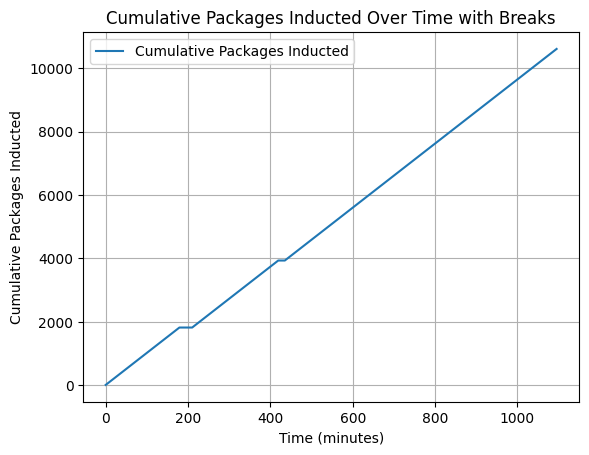

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Given values
TOTAL_PACKAGES = G.TOTAL_PACKAGES  # Example value, replace with actual value
TLMD_INDUCT_TIME = G.TLMD_INDUCT_TIME  # Example value, replace with actual value

induct_rate = G.TOTAL_PACKAGES  / G.TLMD_INDUCT_TIME
full_induct_time = G.TLMD_INDUCT_TIME + 45

break_1 = (180, 210)
break_2 = (420, 435)

# Generate time points
time_points = np.arange(0, full_induct_time + 1)

# Generate cumulative packages inducted with breaks
cumulative_packages = []
cumulative_sum = 0
for t in time_points:
    if break_1[0] <= t <= break_1[1] or break_2[0] <= t <= break_2[1]:
        cumulative_packages.append(cumulative_sum)
    else:
        cumulative_sum += induct_rate
        cumulative_packages.append(cumulative_sum)

# Plot the graph
plt.plot(time_points, cumulative_packages, label='Cumulative Packages Inducted')
plt.xlabel('Time (minutes)')
plt.ylabel('Cumulative Packages Inducted')
plt.title('Cumulative Packages Inducted Over Time with Breaks')
plt.legend()
plt.grid(True)
plt.show()



